# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')

ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'latin-1')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

Total Games: 6644
Total Drives: 171711
Total Plays: 1210285


In [5]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

Clean Drives: 170813


In [6]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [7]:
off_play_types

['Pass Completion',
 'Rush',
 'Pass Incompletion',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [8]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)

In [9]:
pbp_data.head()

index            id        offense offense_conference           defense  \
0      0  322430009008  Arizona State             Pac-12  Northern Arizona   
1      1  322430009009  Arizona State             Pac-12  Northern Arizona   
2      2  322430009011  Arizona State             Pac-12  Northern Arizona   
3      3  322430009013  Arizona State             Pac-12  Northern Arizona   
4      4  322430009005  Arizona State             Pac-12  Northern Arizona   

  defense_conference           home              away  offense_score  \
0                NaN  Arizona State  Northern Arizona              0   
1                NaN  Arizona State  Northern Arizona              0   
2                NaN  Arizona State  Northern Arizona              6   
3                NaN  Arizona State  Northern Arizona              7   
4                NaN  Arizona State  Northern Arizona              0   

   defense_score  ...  clock.seconds  yard_line  down  distance  yards_gained  \
0              0  ...             18         72     2      10.0             3   
1              0  ...             45         75     3       7.0            16   
2              0  ...             26         91     1       9.0             9   
3              0  ...             26         35    -1      -1.0            15   
4              0  ...             11         47     3       6.0             9   

         play_type                                          play_text  \
0  Pass Completion  Taylor Kelly pass complete to D.J. Foster for ...   
1  Pass Completion  Taylor Kelly pass complete to Chris Coyle for ...   
2             Rush  Cameron Marshall rush for 9 yards for a TOUCHD...   
3          Kickoff  Alex Garoutte kickoff for 65 yards returned by...   
4             Rush  Taylor Kelly rush for 9 yards to the NoArz 44 ...   

        ppa  year     EqPPP  
0 -0.220409  2012  0.254253  
1  1.072268  2012  1.855460  
2       NaN  2012  1.648449  
3       NaN  2012  0.000000  
4  2.359414  2012  0.476408  

[5 rows x 23 columns]

In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [11]:
pbp_data.head()

index            id        offense offense_conference           defense  \
0      0  322430009008  Arizona State             Pac-12  Northern Arizona   
1      1  322430009009  Arizona State             Pac-12  Northern Arizona   
2      2  322430009011  Arizona State             Pac-12  Northern Arizona   
3      3  322430009013  Arizona State             Pac-12  Northern Arizona   
4      4  322430009005  Arizona State             Pac-12  Northern Arizona   

  defense_conference           home              away  offense_score  \
0                NaN  Arizona State  Northern Arizona              0   
1                NaN  Arizona State  Northern Arizona              0   
2                NaN  Arizona State  Northern Arizona              6   
3                NaN  Arizona State  Northern Arizona              7   
4                NaN  Arizona State  Northern Arizona              0   

   defense_score  ...  down  distance  yards_gained        play_type  \
0              0  ...     2      10.0             3  Pass Completion   
1              0  ...     3       7.0            16  Pass Completion   
2              0  ...     1       9.0             9             Rush   
3              0  ...    -1      -1.0            15          Kickoff   
4              0  ...     3       6.0             9             Rush   

                                           play_text       ppa  year  \
0  Taylor Kelly pass complete to D.J. Foster for ... -0.220409  2012   
1  Taylor Kelly pass complete to Chris Coyle for ...  1.072268  2012   
2  Cameron Marshall rush for 9 yards for a TOUCHD...       NaN  2012   
3  Alex Garoutte kickoff for 65 yards returned by...       NaN  2012   
4  Taylor Kelly rush for 9 yards to the NoArz 44 ...  2.359414  2012   

      EqPPP play_explosive play_successful  
0  0.254253          False           False  
1  1.855460           True            True  
2  1.648449          False            True  
3  0.000000          False           False  
4  0.476408          False            True  

[5 rows x 25 columns]

In [16]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

def determine_kick_return(row, play_value):
    if "touchback" in row.PlayText:
        return 25
    else:
        return play_value
    
def determine_punt_return(row, play_value):
    if "touchback" in row.PlayText:
        return 20
    else:
        return play_value

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = tmp.values
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: determine_kick_return(x, kickoff_plays.yards_gained[x.Index]),axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = pt_tmp.values
        punt_distance["PlayText"] = punt_distance.apply(lambda x: punt_plays.play_text[x.Index],axis=1)
        punt_distance["Return"] = punt_distance.apply(lambda x: determine_punt_return(x, punt_plays.yards_gained[x.Index]),axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    #return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0       Virginia    2018  401013183  31.0     -3.0        0.875665  0.396825   
1  Virginia Tech    2018  401013183  34.0      3.0        0.124335  0.368421   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.111111  6.507937  0.930578  ...    0.124959      -0.040309     -0.002715   
1  0.078947  5.513158  0.805619  ...   -0.124959       0.040309      0.002715   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0            0.0                  0.0    0.119048          0.119048   
1            0.0                  0.0   -0.119048         -0.119048   

   FGEffDiff       5FR   5FRDiff  
0   0.333333  5.070568  0.141137  
1  -0.333333  4.929432 -0.141137  

[2 rows x 53 columns]

In [17]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

Team       Eff      Expl    FinDrv  FldPos    Trnovr       5FR  \
0       Virginia  5.142022  5.050452  5.386628    4.46  5.017309  5.070568   
1  Virginia Tech  4.857978  4.949548  4.613372    5.54  4.982691  4.929432   

    5FRDiff  
0  0.141137  
1 -0.141137

In [18]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if (('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv"))):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

stored_game_boxes.Team = stored_game_boxes.Team.apply(lambda x: "San Jose State" if (x == "San JosÃÂÃÂ© State") else x)
if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...
[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...
[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...
[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...
[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...
[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...
[8/

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[194/5670] Updated 5FR Margin for game_id 322730103.
[195/5670] Updating 5FR Margin for game_id 322730127...
[195/5670] Updated 5FR Margin for game_id 322730127.
[196/5670] Updating 5FR Margin for game_id 322730151...
[196/5670] Updated 5FR Margin for game_id 322730151.
[197/5670] Updating 5FR Margin for game_id 322730154...
[197/5670] Updated 5FR Margin for game_id 322730154.
[198/5670] Updating 5FR Margin for game_id 322730158...
[198/5670] Updated 5FR Margin for game_id 322730158.
[199/5670] Updating 5FR Margin for game_id 322730166...
[199/5670] Updated 5FR Margin for game_id 322730166.
[200/5670] Updating 5FR Margin for game_id 322730167...
[200/5670] Updated 5FR Margin for game_id 322730167.
[201/5670] Updating 5FR Margin for game_id 322730197...
[201/5670] Updated 5FR Margin for game_id 322730197.
[202/5670] Updating 5FR Margin for game_id 322730242...
[202/5670] Updated 5FR Margin for game_id 322730242.
[203/5670] Updating 5FR Margin for game_id 322730245...
[203/5670] Updated 

[415/5670] Updating 5FR Margin for game_id 323010197...
[415/5670] Updated 5FR Margin for game_id 323010197.
[416/5670] Updating 5FR Margin for game_id 323010201...
[416/5670] Updated 5FR Margin for game_id 323010201.
[417/5670] Updating 5FR Margin for game_id 323010213...
[417/5670] Updated 5FR Margin for game_id 323010213.
[418/5670] Updating 5FR Margin for game_id 323010221...
[418/5670] Updated 5FR Margin for game_id 323010221.
[419/5670] Updating 5FR Margin for game_id 323010238...
[419/5670] Updated 5FR Margin for game_id 323010238.
[420/5670] Updating 5FR Margin for game_id 323010242...
[420/5670] Updated 5FR Margin for game_id 323010242.
[421/5670] Updating 5FR Margin for game_id 323010248...
[421/5670] Updated 5FR Margin for game_id 323010248.
[422/5670] Updating 5FR Margin for game_id 323010254...
[422/5670] Updated 5FR Margin for game_id 323010254.
[423/5670] Updating 5FR Margin for game_id 323010264...
[423/5670] Updated 5FR Margin for game_id 323010264.
[424/5670] Updating

[636/5670] Updating 5FR Margin for game_id 323290153...
[636/5670] Updated 5FR Margin for game_id 323290153.
[637/5670] Updating 5FR Margin for game_id 323290154...
[637/5670] Updated 5FR Margin for game_id 323290154.
[638/5670] Updating 5FR Margin for game_id 323290166...
[638/5670] Updated 5FR Margin for game_id 323290166.
[639/5670] Updating 5FR Margin for game_id 323290194...
[639/5670] Updated 5FR Margin for game_id 323290194.
[640/5670] Updating 5FR Margin for game_id 323290201...
[640/5670] Updated 5FR Margin for game_id 323290201.
[641/5670] Updating 5FR Margin for game_id 323290204...
[641/5670] Updated 5FR Margin for game_id 323290204.
[642/5670] Updating 5FR Margin for game_id 323290213...
[642/5670] Updated 5FR Margin for game_id 323290213.
[643/5670] Updating 5FR Margin for game_id 323290221...
[643/5670] Updated 5FR Margin for game_id 323290221.
[644/5670] Updating 5FR Margin for game_id 323290228...
[644/5670] Updated 5FR Margin for game_id 323290228.
[645/5670] Updating

[856/5670] Updating 5FR Margin for game_id 332700252...
[856/5670] Updated 5FR Margin for game_id 332700252.
[857/5670] Updating 5FR Margin for game_id 332710008...
[857/5670] Updated 5FR Margin for game_id 332710008.
[858/5670] Updating 5FR Margin for game_id 332710009...
[858/5670] Updated 5FR Margin for game_id 332710009.
[859/5670] Updating 5FR Margin for game_id 332710036...
[859/5670] Updated 5FR Margin for game_id 332710036.
[860/5670] Updating 5FR Margin for game_id 332710058...
[860/5670] Updated 5FR Margin for game_id 332710058.
[861/5670] Updating 5FR Margin for game_id 332710061...
[861/5670] Updated 5FR Margin for game_id 332710061.
[862/5670] Updating 5FR Margin for game_id 332710062...
[862/5670] Updated 5FR Margin for game_id 332710062.
[863/5670] Updating 5FR Margin for game_id 332710068...
[863/5670] Updated 5FR Margin for game_id 332710068.
[864/5670] Updating 5FR Margin for game_id 332710087...
[864/5670] Updated 5FR Margin for game_id 332710087.
[865/5670] Updating

[1075/5670] Updated 5FR Margin for game_id 332990201.
[1076/5670] Updating 5FR Margin for game_id 332990204...
[1076/5670] Updated 5FR Margin for game_id 332990204.
[1077/5670] Updating 5FR Margin for game_id 332990242...
[1077/5670] Updated 5FR Margin for game_id 332990242.
[1078/5670] Updating 5FR Margin for game_id 332990245...
[1078/5670] Updated 5FR Margin for game_id 332990245.
[1079/5670] Updating 5FR Margin for game_id 332990258...
[1079/5670] Updated 5FR Margin for game_id 332990258.
[1080/5670] Updating 5FR Margin for game_id 332990259...
[1080/5670] Updated 5FR Margin for game_id 332990259.
[1081/5670] Updating 5FR Margin for game_id 332990264...
[1081/5670] Updated 5FR Margin for game_id 332990264.
[1082/5670] Updating 5FR Margin for game_id 332990326...
[1082/5670] Updated 5FR Margin for game_id 332990326.
[1083/5670] Updating 5FR Margin for game_id 332990333...
[1083/5670] Updated 5FR Margin for game_id 332990333.
[1084/5670] Updating 5FR Margin for game_id 332990356...
[

[1294/5670] Updating 5FR Margin for game_id 333272117...
[1294/5670] Updated 5FR Margin for game_id 333272117.
[1295/5670] Updating 5FR Margin for game_id 333272199...
[1295/5670] Updated 5FR Margin for game_id 333272199.
[1296/5670] Updating 5FR Margin for game_id 333272226...
[1296/5670] Updated 5FR Margin for game_id 333272226.
[1297/5670] Updating 5FR Margin for game_id 333272229...
[1297/5670] Updated 5FR Margin for game_id 333272229.
[1298/5670] Updating 5FR Margin for game_id 333272294...
[1298/5670] Updated 5FR Margin for game_id 333272294.
[1299/5670] Updating 5FR Margin for game_id 333272306...
[1299/5670] Updated 5FR Margin for game_id 333272306.
[1300/5670] Updating 5FR Margin for game_id 333272348...
[1300/5670] Updated 5FR Margin for game_id 333272348.
[1301/5670] Updating 5FR Margin for game_id 333272390...
[1301/5670] Updated 5FR Margin for game_id 333272390.
[1302/5670] Updating 5FR Margin for game_id 333272509...
[1302/5670] Updated 5FR Margin for game_id 333272509.
[

[1513/5670] Updated 5FR Margin for game_id 400547790.
[1514/5670] Updating 5FR Margin for game_id 400547791...
[1514/5670] Updated 5FR Margin for game_id 400547791.
[1515/5670] Updating 5FR Margin for game_id 400547792...
[1515/5670] Updated 5FR Margin for game_id 400547792.
[1516/5670] Updating 5FR Margin for game_id 400547793...
[1516/5670] Updated 5FR Margin for game_id 400547793.
[1517/5670] Updating 5FR Margin for game_id 400547794...
[1517/5670] Updated 5FR Margin for game_id 400547794.
[1518/5670] Updating 5FR Margin for game_id 400547795...
[1518/5670] Updated 5FR Margin for game_id 400547795.
[1519/5670] Updating 5FR Margin for game_id 400547796...
[1519/5670] Updated 5FR Margin for game_id 400547796.
[1520/5670] Updating 5FR Margin for game_id 400547797...
[1520/5670] Updated 5FR Margin for game_id 400547797.
[1521/5670] Updating 5FR Margin for game_id 400547798...
[1521/5670] Updated 5FR Margin for game_id 400547798.
[1522/5670] Updating 5FR Margin for game_id 400547799...
[

[1728/5670] Updating 5FR Margin for game_id 400548042...
[1728/5670] Updated 5FR Margin for game_id 400548042.
[1729/5670] Updating 5FR Margin for game_id 400548043...
[1729/5670] Updated 5FR Margin for game_id 400548043.
[1730/5670] Updating 5FR Margin for game_id 400548044...
[1730/5670] Updated 5FR Margin for game_id 400548044.
[1731/5670] Updating 5FR Margin for game_id 400548045...
[1731/5670] Updated 5FR Margin for game_id 400548045.
[1732/5670] Updating 5FR Margin for game_id 400548046...
[1732/5670] Updated 5FR Margin for game_id 400548046.
[1733/5670] Updating 5FR Margin for game_id 400548047...
[1733/5670] Updated 5FR Margin for game_id 400548047.
[1734/5670] Updating 5FR Margin for game_id 400548048...
[1734/5670] Updated 5FR Margin for game_id 400548048.
[1735/5670] Updating 5FR Margin for game_id 400548049...
[1735/5670] Updated 5FR Margin for game_id 400548049.
[1736/5670] Updating 5FR Margin for game_id 400548050...
[1736/5670] Updated 5FR Margin for game_id 400548050.
[

[1944/5670] Updated 5FR Margin for game_id 400548304.
[1945/5670] Updating 5FR Margin for game_id 400548305...
[1945/5670] Updated 5FR Margin for game_id 400548305.
[1946/5670] Updating 5FR Margin for game_id 400548306...
[1946/5670] Updated 5FR Margin for game_id 400548306.
[1947/5670] Updating 5FR Margin for game_id 400548307...
[1947/5670] Updated 5FR Margin for game_id 400548307.
[1948/5670] Updating 5FR Margin for game_id 400548308...
[1948/5670] Updated 5FR Margin for game_id 400548308.
[1949/5670] Updating 5FR Margin for game_id 400548309...
[1949/5670] Updated 5FR Margin for game_id 400548309.
[1950/5670] Updating 5FR Margin for game_id 400548310...
[1950/5670] Updated 5FR Margin for game_id 400548310.
[1951/5670] Updating 5FR Margin for game_id 400548311...
[1951/5670] Updated 5FR Margin for game_id 400548311.
[1952/5670] Updating 5FR Margin for game_id 400548312...
[1952/5670] Updated 5FR Margin for game_id 400548312.
[1953/5670] Updating 5FR Margin for game_id 400548313...
[

[2172/5670] Updating 5FR Margin for game_id 400609098...
[2172/5670] Updated 5FR Margin for game_id 400609098.
[2173/5670] Updating 5FR Margin for game_id 400609154...
[2173/5670] Updated 5FR Margin for game_id 400609154.
[2174/5670] Updating 5FR Margin for game_id 400756882...
[2174/5670] Updated 5FR Margin for game_id 400756882.
[2175/5670] Updating 5FR Margin for game_id 400756883...
[2175/5670] Updated 5FR Margin for game_id 400756883.
[2176/5670] Updating 5FR Margin for game_id 400756884...
[2176/5670] Updated 5FR Margin for game_id 400756884.
[2177/5670] Updating 5FR Margin for game_id 400756888...
[2177/5670] Updated 5FR Margin for game_id 400756888.
[2178/5670] Updating 5FR Margin for game_id 400756891...
[2178/5670] Updated 5FR Margin for game_id 400756891.
[2179/5670] Updating 5FR Margin for game_id 400756892...
[2179/5670] Updated 5FR Margin for game_id 400756892.
[2180/5670] Updating 5FR Margin for game_id 400756894...
[2180/5670] Updated 5FR Margin for game_id 400756894.
[

[2390/5670] Updated 5FR Margin for game_id 400763450.
[2391/5670] Updating 5FR Margin for game_id 400763451...
[2391/5670] Updated 5FR Margin for game_id 400763451.
[2392/5670] Updating 5FR Margin for game_id 400763452...
[2392/5670] Updated 5FR Margin for game_id 400763452.
[2393/5670] Updating 5FR Margin for game_id 400763453...
[2393/5670] Updated 5FR Margin for game_id 400763453.
[2394/5670] Updating 5FR Margin for game_id 400763454...
[2394/5670] Updated 5FR Margin for game_id 400763454.
[2395/5670] Updating 5FR Margin for game_id 400763455...
[2395/5670] Updated 5FR Margin for game_id 400763455.
[2396/5670] Updating 5FR Margin for game_id 400763456...
[2396/5670] Updated 5FR Margin for game_id 400763456.
[2397/5670] Updating 5FR Margin for game_id 400763457...
[2397/5670] Updated 5FR Margin for game_id 400763457.
[2398/5670] Updating 5FR Margin for game_id 400763458...
[2398/5670] Updated 5FR Margin for game_id 400763458.
[2399/5670] Updating 5FR Margin for game_id 400763459...
[

[2614/5670] Updated 5FR Margin for game_id 400764913.
[2615/5670] Updating 5FR Margin for game_id 400764914...
[2615/5670] Updated 5FR Margin for game_id 400764914.
[2616/5670] Updating 5FR Margin for game_id 400764915...
[2616/5670] Updated 5FR Margin for game_id 400764915.
[2617/5670] Updating 5FR Margin for game_id 400764916...
[2617/5670] Updated 5FR Margin for game_id 400764916.
[2618/5670] Updating 5FR Margin for game_id 400764917...
[2618/5670] Updated 5FR Margin for game_id 400764917.
[2619/5670] Updating 5FR Margin for game_id 400764918...
[2619/5670] Updated 5FR Margin for game_id 400764918.
[2620/5670] Updating 5FR Margin for game_id 400764919...
[2620/5670] Updated 5FR Margin for game_id 400764919.
[2621/5670] Updating 5FR Margin for game_id 400764920...
[2621/5670] Updated 5FR Margin for game_id 400764920.
[2622/5670] Updating 5FR Margin for game_id 400764921...
[2622/5670] Updated 5FR Margin for game_id 400764921.
[2623/5670] Updating 5FR Margin for game_id 400764922...
[

[2837/5670] Updating 5FR Margin for game_id 400868967...
[2837/5670] Updated 5FR Margin for game_id 400868967.
[2838/5670] Updating 5FR Margin for game_id 400868968...
[2838/5670] Updated 5FR Margin for game_id 400868968.
[2839/5670] Updating 5FR Margin for game_id 400868969...
[2839/5670] Updated 5FR Margin for game_id 400868969.
[2840/5670] Updating 5FR Margin for game_id 400868970...
[2840/5670] Updated 5FR Margin for game_id 400868970.
[2841/5670] Updating 5FR Margin for game_id 400868971...
[2841/5670] Updated 5FR Margin for game_id 400868971.
[2842/5670] Updating 5FR Margin for game_id 400868972...
[2842/5670] Updated 5FR Margin for game_id 400868972.
[2843/5670] Updating 5FR Margin for game_id 400868973...
[2843/5670] Updated 5FR Margin for game_id 400868973.
[2844/5670] Updating 5FR Margin for game_id 400868974...
[2844/5670] Updated 5FR Margin for game_id 400868974.
[2845/5670] Updating 5FR Margin for game_id 400868975...
[2845/5670] Updated 5FR Margin for game_id 400868975.
[

[3058/5670] Updating 5FR Margin for game_id 400869243...
[3058/5670] Updated 5FR Margin for game_id 400869243.
[3059/5670] Updating 5FR Margin for game_id 400869244...
[3059/5670] Updated 5FR Margin for game_id 400869244.
[3060/5670] Updating 5FR Margin for game_id 400869245...
[3060/5670] Updated 5FR Margin for game_id 400869245.
[3061/5670] Updating 5FR Margin for game_id 400869246...
[3061/5670] Updated 5FR Margin for game_id 400869246.
[3062/5670] Updating 5FR Margin for game_id 400869247...
[3062/5670] Updated 5FR Margin for game_id 400869247.
[3063/5670] Updating 5FR Margin for game_id 400869248...
[3063/5670] Updated 5FR Margin for game_id 400869248.
[3064/5670] Updating 5FR Margin for game_id 400869249...
[3064/5670] Updated 5FR Margin for game_id 400869249.
[3065/5670] Updating 5FR Margin for game_id 400869250...
[3065/5670] Updated 5FR Margin for game_id 400869250.
[3066/5670] Updating 5FR Margin for game_id 400869251...
[3066/5670] Updated 5FR Margin for game_id 400869251.
[

[3278/5670] Updating 5FR Margin for game_id 400869512...
[3278/5670] Updated 5FR Margin for game_id 400869512.
[3279/5670] Updating 5FR Margin for game_id 400869516...
[3279/5670] Updated 5FR Margin for game_id 400869516.
[3280/5670] Updating 5FR Margin for game_id 400869517...
[3280/5670] Updated 5FR Margin for game_id 400869517.
[3281/5670] Updating 5FR Margin for game_id 400869518...
[3281/5670] Updated 5FR Margin for game_id 400869518.
[3282/5670] Updating 5FR Margin for game_id 400869519...
[3282/5670] Updated 5FR Margin for game_id 400869519.
[3283/5670] Updating 5FR Margin for game_id 400869520...
[3283/5670] Updated 5FR Margin for game_id 400869520.
[3284/5670] Updating 5FR Margin for game_id 400869521...
[3284/5670] Updated 5FR Margin for game_id 400869521.
[3285/5670] Updating 5FR Margin for game_id 400869522...
[3285/5670] Updated 5FR Margin for game_id 400869522.
[3286/5670] Updating 5FR Margin for game_id 400869524...
[3286/5670] Updated 5FR Margin for game_id 400869524.
[

[3499/5670] Updated 5FR Margin for game_id 400933843.
[3500/5670] Updating 5FR Margin for game_id 400933845...
[3500/5670] Updated 5FR Margin for game_id 400933845.
[3501/5670] Updating 5FR Margin for game_id 400933849...
[3501/5670] Updated 5FR Margin for game_id 400933849.
[3502/5670] Updating 5FR Margin for game_id 400933850...
[3502/5670] Updated 5FR Margin for game_id 400933850.
[3503/5670] Updating 5FR Margin for game_id 400933854...
[3503/5670] Updated 5FR Margin for game_id 400933854.
[3504/5670] Updating 5FR Margin for game_id 400933856...
[3504/5670] Updated 5FR Margin for game_id 400933856.
[3505/5670] Updating 5FR Margin for game_id 400933858...
[3505/5670] Updated 5FR Margin for game_id 400933858.
[3506/5670] Updating 5FR Margin for game_id 400933859...
[3506/5670] Updated 5FR Margin for game_id 400933859.
[3507/5670] Updating 5FR Margin for game_id 400933860...
[3507/5670] Updated 5FR Margin for game_id 400933860.
[3508/5670] Updating 5FR Margin for game_id 400933861...
[

[3720/5670] Updating 5FR Margin for game_id 400935287...
[3720/5670] Updated 5FR Margin for game_id 400935287.
[3721/5670] Updating 5FR Margin for game_id 400935288...
[3721/5670] Updated 5FR Margin for game_id 400935288.
[3722/5670] Updating 5FR Margin for game_id 400935289...
[3722/5670] Updated 5FR Margin for game_id 400935289.
[3723/5670] Updating 5FR Margin for game_id 400935290...
[3723/5670] Updated 5FR Margin for game_id 400935290.
[3724/5670] Updating 5FR Margin for game_id 400935291...
[3724/5670] Updated 5FR Margin for game_id 400935291.
[3725/5670] Updating 5FR Margin for game_id 400935292...
[3725/5670] Updated 5FR Margin for game_id 400935292.
[3726/5670] Updating 5FR Margin for game_id 400935293...
[3726/5670] Updated 5FR Margin for game_id 400935293.
[3727/5670] Updating 5FR Margin for game_id 400935294...
[3727/5670] Updated 5FR Margin for game_id 400935294.
[3728/5670] Updating 5FR Margin for game_id 400935295...
[3728/5670] Updated 5FR Margin for game_id 400935295.
[

[3941/5670] Updated 5FR Margin for game_id 400938635.
[3942/5670] Updating 5FR Margin for game_id 400938636...
[3942/5670] Updated 5FR Margin for game_id 400938636.
[3943/5670] Updating 5FR Margin for game_id 400938637...
[3943/5670] Updated 5FR Margin for game_id 400938637.
[3944/5670] Updating 5FR Margin for game_id 400938638...
[3944/5670] Updated 5FR Margin for game_id 400938638.
[3945/5670] Updating 5FR Margin for game_id 400938639...
[3945/5670] Updated 5FR Margin for game_id 400938639.
[3946/5670] Updating 5FR Margin for game_id 400938640...
[3946/5670] Updated 5FR Margin for game_id 400938640.
[3947/5670] Updating 5FR Margin for game_id 400938641...
[3947/5670] Updated 5FR Margin for game_id 400938641.
[3948/5670] Updating 5FR Margin for game_id 400938642...
[3948/5670] Updated 5FR Margin for game_id 400938642.
[3949/5670] Updating 5FR Margin for game_id 400938643...
[3949/5670] Updated 5FR Margin for game_id 400938643.
[3950/5670] Updating 5FR Margin for game_id 400938644...
[

[4163/5670] Updated 5FR Margin for game_id 400945282.
[4164/5670] Updating 5FR Margin for game_id 400945283...
[4164/5670] Updated 5FR Margin for game_id 400945283.
[4165/5670] Updating 5FR Margin for game_id 400945284...
[4165/5670] Updated 5FR Margin for game_id 400945284.
[4166/5670] Updating 5FR Margin for game_id 400945285...
[4166/5670] Updated 5FR Margin for game_id 400945285.
[4167/5670] Updating 5FR Margin for game_id 400945286...
[4167/5670] Updated 5FR Margin for game_id 400945286.
[4168/5670] Updating 5FR Margin for game_id 400945287...
[4168/5670] Updated 5FR Margin for game_id 400945287.
[4169/5670] Updating 5FR Margin for game_id 400945288...
[4169/5670] Updated 5FR Margin for game_id 400945288.
[4170/5670] Updating 5FR Margin for game_id 400945289...
[4170/5670] Updated 5FR Margin for game_id 400945289.
[4171/5670] Updating 5FR Margin for game_id 400945290...
[4171/5670] Updated 5FR Margin for game_id 400945290.
[4172/5670] Updating 5FR Margin for game_id 400945291...
[

[4380/5670] Updated 5FR Margin for game_id 401012803.
[4381/5670] Updating 5FR Margin for game_id 401012804...
[4381/5670] Updated 5FR Margin for game_id 401012804.
[4382/5670] Updating 5FR Margin for game_id 401012806...
[4382/5670] Updated 5FR Margin for game_id 401012806.
[4383/5670] Updating 5FR Margin for game_id 401012807...
[4383/5670] Updated 5FR Margin for game_id 401012807.
[4384/5670] Updating 5FR Margin for game_id 401012808...
[4384/5670] Updated 5FR Margin for game_id 401012808.
[4385/5670] Updating 5FR Margin for game_id 401012809...
[4385/5670] Updated 5FR Margin for game_id 401012809.
[4386/5670] Updating 5FR Margin for game_id 401012810...
[4386/5670] Updated 5FR Margin for game_id 401012810.
[4387/5670] Updating 5FR Margin for game_id 401012811...
[4387/5670] Updated 5FR Margin for game_id 401012811.
[4388/5670] Updating 5FR Margin for game_id 401012812...
[4388/5670] Updated 5FR Margin for game_id 401012812.
[4389/5670] Updating 5FR Margin for game_id 401012813...
[

[4602/5670] Updated 5FR Margin for game_id 401013344.
[4603/5670] Updating 5FR Margin for game_id 401013345...
[4603/5670] Updated 5FR Margin for game_id 401013345.
[4604/5670] Updating 5FR Margin for game_id 401013346...
[4604/5670] Updated 5FR Margin for game_id 401013346.
[4605/5670] Updating 5FR Margin for game_id 401013347...
[4605/5670] Updated 5FR Margin for game_id 401013347.
[4606/5670] Updating 5FR Margin for game_id 401013348...
[4606/5670] Updated 5FR Margin for game_id 401013348.
[4607/5670] Updating 5FR Margin for game_id 401013349...
[4607/5670] Updated 5FR Margin for game_id 401013349.
[4608/5670] Updating 5FR Margin for game_id 401013350...
[4608/5670] Updated 5FR Margin for game_id 401013350.
[4609/5670] Updating 5FR Margin for game_id 401013351...
[4609/5670] Updated 5FR Margin for game_id 401013351.
[4610/5670] Updating 5FR Margin for game_id 401013352...
[4610/5670] Updated 5FR Margin for game_id 401013352.
[4611/5670] Updating 5FR Margin for game_id 401013353...
[

[4822/5670] Updating 5FR Margin for game_id 401020782...
[4822/5670] Updated 5FR Margin for game_id 401020782.
[4823/5670] Updating 5FR Margin for game_id 401020783...
[4823/5670] Updated 5FR Margin for game_id 401020783.
[4824/5670] Updating 5FR Margin for game_id 401020784...
[4824/5670] Updated 5FR Margin for game_id 401020784.
[4825/5670] Updating 5FR Margin for game_id 401020785...
[4825/5670] Updated 5FR Margin for game_id 401020785.
[4826/5670] Updating 5FR Margin for game_id 401020786...
[4826/5670] Updated 5FR Margin for game_id 401020786.
[4827/5670] Updating 5FR Margin for game_id 401020787...
[4827/5670] Updated 5FR Margin for game_id 401020787.
[4828/5670] Updating 5FR Margin for game_id 401020788...
[4828/5670] Updated 5FR Margin for game_id 401020788.
[4829/5670] Updating 5FR Margin for game_id 401020789...
[4829/5670] Updated 5FR Margin for game_id 401020789.
[4830/5670] Updating 5FR Margin for game_id 401020790...
[4830/5670] Updated 5FR Margin for game_id 401020790.
[

[5044/5670] Updating 5FR Margin for game_id 401112080...
[5044/5670] Updated 5FR Margin for game_id 401112080.
[5045/5670] Updating 5FR Margin for game_id 401112081...
[5045/5670] Updated 5FR Margin for game_id 401112081.
[5046/5670] Updating 5FR Margin for game_id 401112082...
[5046/5670] Updated 5FR Margin for game_id 401112082.
[5047/5670] Updating 5FR Margin for game_id 401112083...
[5047/5670] Updated 5FR Margin for game_id 401112083.
[5048/5670] Updating 5FR Margin for game_id 401112084...
[5048/5670] Updated 5FR Margin for game_id 401112084.
[5049/5670] Updating 5FR Margin for game_id 401112086...
[5049/5670] Updated 5FR Margin for game_id 401112086.
[5050/5670] Updating 5FR Margin for game_id 401112087...
[5050/5670] Updated 5FR Margin for game_id 401112087.
[5051/5670] Updating 5FR Margin for game_id 401112088...
[5051/5670] Updated 5FR Margin for game_id 401112088.
[5052/5670] Updating 5FR Margin for game_id 401112089...
[5052/5670] Updated 5FR Margin for game_id 401112089.
[

[5266/5670] Updating 5FR Margin for game_id 401112512...
[5266/5670] Updated 5FR Margin for game_id 401112512.
[5267/5670] Updating 5FR Margin for game_id 401112513...
[5267/5670] Updated 5FR Margin for game_id 401112513.
[5268/5670] Updating 5FR Margin for game_id 401112514...
[5268/5670] Updated 5FR Margin for game_id 401112514.
[5269/5670] Updating 5FR Margin for game_id 401112515...
[5269/5670] Updated 5FR Margin for game_id 401112515.
[5270/5670] Updating 5FR Margin for game_id 401112516...
[5270/5670] Updated 5FR Margin for game_id 401112516.
[5271/5670] Updating 5FR Margin for game_id 401112517...
[5271/5670] Updated 5FR Margin for game_id 401112517.
[5272/5670] Updating 5FR Margin for game_id 401112519...
[5272/5670] Updated 5FR Margin for game_id 401112519.
[5273/5670] Updating 5FR Margin for game_id 401112520...
[5273/5670] Updated 5FR Margin for game_id 401112520.
[5274/5670] Updating 5FR Margin for game_id 401112521...
[5274/5670] Updated 5FR Margin for game_id 401112521.
[

[5487/5670] Updated 5FR Margin for game_id 401117532.
[5488/5670] Updating 5FR Margin for game_id 401117533...
[5488/5670] Updated 5FR Margin for game_id 401117533.
[5489/5670] Updating 5FR Margin for game_id 401117534...
[5489/5670] Updated 5FR Margin for game_id 401117534.
[5490/5670] Updating 5FR Margin for game_id 401117535...
[5490/5670] Updated 5FR Margin for game_id 401117535.
[5491/5670] Updating 5FR Margin for game_id 401117536...
[5491/5670] Updated 5FR Margin for game_id 401117536.
[5492/5670] Updating 5FR Margin for game_id 401117537...
[5492/5670] Updated 5FR Margin for game_id 401117537.
[5493/5670] Updating 5FR Margin for game_id 401117538...
[5493/5670] Updated 5FR Margin for game_id 401117538.
[5494/5670] Updating 5FR Margin for game_id 401117540...
[5494/5670] Updated 5FR Margin for game_id 401117540.
[5495/5670] Updating 5FR Margin for game_id 401117541...
[5495/5670] Updated 5FR Margin for game_id 401117541.
[5496/5670] Updating 5FR Margin for game_id 401117542...
[

[Local] Wrote updated box scores to file.


In [19]:
stored_game_boxes.head()

Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  \
0               UCF    2012  322432006  56.0     42.0        0.796214   
1             Akron    2012  322432006  14.0    -42.0        0.203786   
2    South Carolina    2012  322430238  17.0      4.0        0.518995   
3        Vanderbilt    2012  322430238  13.0     -4.0        0.481005   
4  Eastern Michigan    2012  322432050  26.0    -11.0        0.020080   

      OffSR     DefSR     OffER       YPP  ...  SackRateDiff  KickoffSRDiff  \
0  0.492537  0.382716  0.074627  6.029851  ...      0.007186       0.388889   
1  0.382716  0.492537  0.061728  4.370370  ...     -0.007186      -0.388889   
2  0.435484  0.271186  0.080645  5.129032  ...      0.036359      -0.333333   
3  0.271186  0.435484  0.152542  5.813559  ...     -0.036359       0.333333   
4  0.447761  0.510417  0.134328  6.119403  ...      0.010417      -0.416667   

   KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  FGEffDiff       5FR  \
0             0.000000    0.200000          0.200000   0.000000  5.453906   
1             0.000000   -0.200000         -0.200000   0.000000  4.546094   
2            -0.333333   -0.250000         -0.250000   0.333333  5.207552   
3             0.333333    0.250000          0.250000  -0.333333  4.792448   
4            -0.541667   -0.095238         -0.095238  -0.750000  4.744612   

    5FRDiff  5fr_z_score  pts_z_score  
0  0.656305     0.860864     1.907384  
1 -0.656305     0.860864     1.907384  
2  0.597540     0.783782     0.181656  
3 -0.597540     0.783782     0.181656  
4 -0.335597     0.440197     0.499553  

[5 rows x 56 columns]

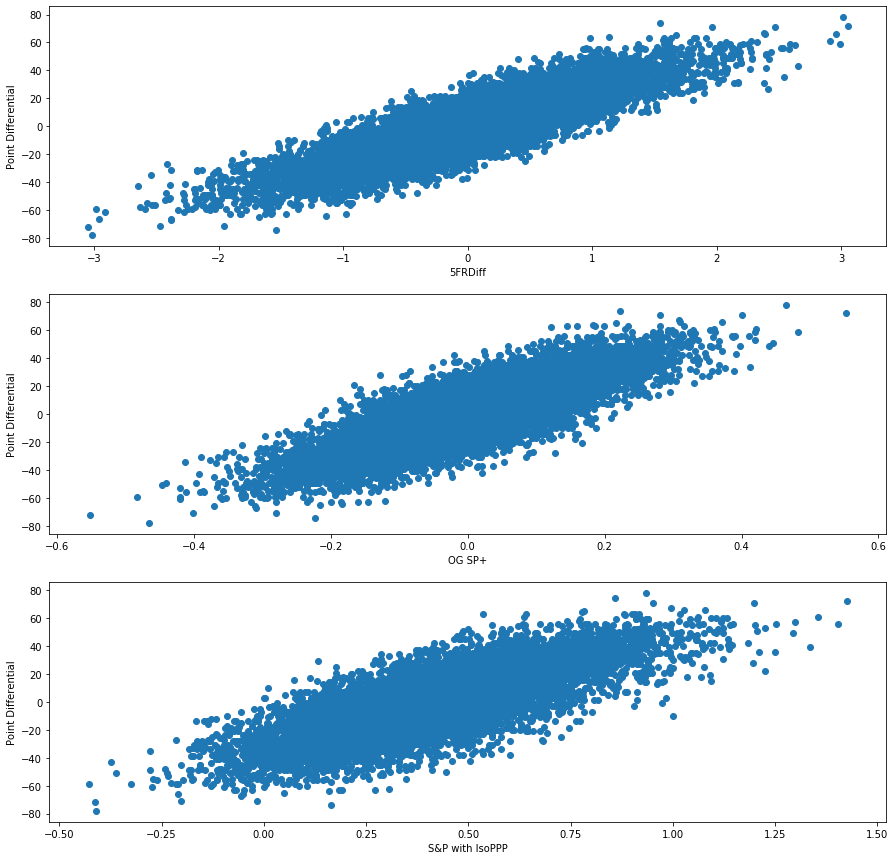

In [20]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [21]:
fg = px.scatter(stored_game_boxes, x="5FRDiff", y="PtsDiff", trendline="lowess")
fg.update_layout(
    title="5FR Margin vs Point Margin (2012-2019)",
    xaxis_title="5FR Margin",
    yaxis_title="Point Margin")
fg.show()

In [22]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

OGS&PDiff  S&PIsoPPPDiff   PtsDiff
OGS&PDiff       1.000000       0.911990  0.759463
S&PIsoPPPDiff   0.911990       1.000000  0.816783
PtsDiff         0.759463       0.816783  1.000000

In [23]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  \
0               UCF    2012  322432006  56.0     42.0        0.796214   
1             Akron    2012  322432006  14.0    -42.0        0.203786   
2    South Carolina    2012  322430238  17.0      4.0        0.518995   
3        Vanderbilt    2012  322430238  13.0     -4.0        0.481005   
4  Eastern Michigan    2012  322432050  26.0    -11.0        0.020080   

      OffSR     DefSR     OffER       YPP  ...  SackRateDiff  KickoffSRDiff  \
0  0.492537  0.382716  0.074627  6.029851  ...      0.007186       0.388889   
1  0.382716  0.492537  0.061728  4.370370  ...     -0.007186      -0.388889   
2  0.435484  0.271186  0.080645  5.129032  ...      0.036359      -0.333333   
3  0.271186  0.435484  0.152542  5.813559  ...     -0.036359       0.333333   
4  0.447761  0.510417  0.134328  6.119403  ...      0.010417      -0.416667   

   KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  FGEffDiff       5FR  \
0             0.000000    0.200000          0.200000   0.000000  5.453906   
1             0.000000   -0.200000         -0.200000   0.000000  4.546094   
2            -0.333333   -0.250000         -0.250000   0.333333  5.207552   
3             0.333333    0.250000          0.250000  -0.333333  4.792448   
4            -0.541667   -0.095238         -0.095238  -0.750000  4.744612   

    5FRDiff  5fr_z_score  pts_z_score  
0  0.656305     0.860864     1.907384  
1 -0.656305     0.860864     1.907384  
2  0.597540     0.783782     0.181656  
3 -0.597540     0.783782     0.181656  
4 -0.335597     0.440197     0.499553  

[5 rows x 56 columns]

In [24]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [25]:
# outliers

In [26]:
train_data.head()

Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  \
0               UCF    2012  322432006  56.0     42.0        0.796214   
1             Akron    2012  322432006  14.0    -42.0        0.203786   
2    South Carolina    2012  322430238  17.0      4.0        0.518995   
3        Vanderbilt    2012  322430238  13.0     -4.0        0.481005   
4  Eastern Michigan    2012  322432050  26.0    -11.0        0.020080   

      OffSR     DefSR     OffER       YPP  ...  SackRateDiff  KickoffSRDiff  \
0  0.492537  0.382716  0.074627  6.029851  ...      0.007186       0.388889   
1  0.382716  0.492537  0.061728  4.370370  ...     -0.007186      -0.388889   
2  0.435484  0.271186  0.080645  5.129032  ...      0.036359      -0.333333   
3  0.271186  0.435484  0.152542  5.813559  ...     -0.036359       0.333333   
4  0.447761  0.510417  0.134328  6.119403  ...      0.010417      -0.416667   

   KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  FGEffDiff       5FR  \
0             0.000000    0.200000          0.200000   0.000000  5.453906   
1             0.000000   -0.200000         -0.200000   0.000000  4.546094   
2            -0.333333   -0.250000         -0.250000   0.333333  5.207552   
3             0.333333    0.250000          0.250000  -0.333333  4.792448   
4            -0.541667   -0.095238         -0.095238  -0.750000  4.744612   

    5FRDiff  5fr_z_score  pts_z_score  
0  0.656305     0.860864     1.907384  
1 -0.656305     0.860864     1.907384  
2  0.597540     0.783782     0.181656  
3 -0.597540     0.783782     0.181656  
4 -0.335597     0.440197     0.499553  

[5 rows x 56 columns]

In [27]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [28]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)


r_2 = r2_score(test_data["PtsDiff"][:,np.newaxis], preds)
print(f'R-squared: {r_2}')

def adj_r2_score(R, n, p): 
    return 1-(1-R)*(n-1)/(n-p-1)
adj_r2 = adj_r2_score(r_2, len(test_data["PtsDiff"]), 1)
print(f'Adj R-squared: {adj_r2}\n')
    
test.corr()

Linear Regression: y = 25.21527x + 0.04705
Mean Pred Score: 0.0041603216030261505
Pred Std Dev: 19.095687028287493
Mean Abs Error: 8.31002858489771
Mdn Abs Error: 6.744661310222959
R-squared: 0.7613255371768092
Adj R-squared: 0.7612158017916031



ActPtsDiff  OffSRDiff  OffERDiff    FPDiff  OppRateDiff  \
ActPtsDiff             1.000000   0.775163   0.586899  0.491213     0.805689   
OffSRDiff              0.775163   1.000000   0.496407  0.302610     0.712962   
OffERDiff              0.586899   0.496407   1.000000  0.178003     0.512432   
FPDiff                 0.491213   0.302610   0.178003  1.000000     0.601979   
OppRateDiff            0.805689   0.712962   0.512432  0.601979     1.000000   
OppEffDiff             0.620887   0.420474   0.342638  0.115506     0.244978   
OppPPDDiff             0.611273   0.455793   0.334350  0.111513     0.232664   
PPDDiff                0.983067   0.770673   0.572756  0.468510     0.803482   
OppSRDiff              0.526979   0.749884   0.353096  0.066832     0.291037   
YPPDiff                0.789133   0.726822   0.810659  0.241921     0.677854   
ExpTODiff             -0.452305  -0.312720  -0.208383 -0.278744    -0.317712   
ActualTODiff          -0.444685  -0.188775  -0.103129 -0.364739    -0.299982   
AvgEqPPPDiff           0.736099   0.651897   0.765325  0.232300     0.606211   
TotalEqPPPDiff         0.766160   0.763811   0.620992  0.224452     0.747738   
IsoPPPDiff             0.249083  -0.048826   0.559847  0.029352     0.144157   
HavocRateDiff          0.525043   0.533203   0.192586  0.253605     0.490452   
SackRateDiff           0.457427   0.399970   0.204517  0.262545     0.415521   
KickoffSRDiff          0.252055   0.200388   0.122808  0.323250     0.244233   
KickoffReturnSRDiff    0.159382   0.112488   0.057403  0.271058     0.170368   
PuntSRDiff             0.058295  -0.003375   0.020844  0.228624     0.049932   
PuntReturnSRDiff       0.105367   0.037241   0.050662  0.243827     0.101054   
FGEffDiff              0.182629   0.092184   0.104960  0.142277     0.213525   
5FR                    0.899758   0.921635   0.532165  0.567028     0.829979   
5FRDiff                0.872617   0.966594   0.558206  0.373211     0.776845   
PredPtsDiff            0.872617   0.966594   0.558206  0.373211     0.776845   

                     OppEffDiff  OppPPDDiff   PPDDiff  OppSRDiff   YPPDiff  \
ActPtsDiff             0.620887    0.611273  0.983067   0.526979  0.789133   
OffSRDiff              0.420474    0.455793  0.770673   0.749884  0.726822   
OffERDiff              0.342638    0.334350  0.572756   0.353096  0.810659   
FPDiff                 0.115506    0.111513  0.468510   0.066832  0.241921   
OppRateDiff            0.244978    0.232664  0.803482   0.291037  0.677854   
OppEffDiff             1.000000    0.745577  0.615735   0.501840  0.470270   
OppPPDDiff             0.745577    1.000000  0.617039   0.550903  0.486912   
PPDDiff                0.615735    0.617039  1.000000   0.519233  0.776096   
OppSRDiff              0.501840    0.550903  0.519233   1.000000  0.532550   
YPPDiff                0.470270    0.486912  0.776096   0.532550  1.000000   
ExpTODiff             -0.286155   -0.308693 -0.440936  -0.263213 -0.337159   
ActualTODiff          -0.311972   -0.308633 -0.435143  -0.130896 -0.206746   
AvgEqPPPDiff           0.445476    0.464035  0.724188   0.491886  0.924742   
TotalEqPPPDiff         0.399042    0.395154  0.744656   0.460465  0.806221   
IsoPPPDiff             0.206716    0.195560  0.239607  -0.025225  0.522918   
HavocRateDiff          0.300781    0.354063  0.531186   0.356713  0.438069   
SackRateDiff           0.254036    0.300383  0.457665   0.253623  0.393107   
KickoffSRDiff          0.135809    0.119907  0.248595   0.128529  0.158301   
KickoffReturnSRDiff    0.052301    0.053319  0.146722   0.051108  0.080365   
PuntSRDiff             0.012833    0.011977  0.055459  -0.018810  0.001799   
PuntReturnSRDiff       0.037382    0.032816  0.108553  -0.004327  0.038214   
FGEffDiff              0.383414    0.067047  0.173944  -0.024276  0.125240   
5FR                    0.511064    0.574190  0.891452   0.668642  0.761787   
5FRDiff                0.532435    0.605217  0.869634   0.740940  0.

In [29]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

ActPtsDiff    ActPts       Eff      Expl    FinDrv    FldPos  \
ActPtsDiff     1.000000  0.752559  0.775163  0.736099  0.905240  0.491213   
ActPts         0.752559  1.000000  0.572864  0.562958  0.676751  0.362103   
Eff            0.775163  0.572864  1.000000  0.651897  0.812170  0.302610   
Expl           0.736099  0.562958  0.651897  1.000000  0.702175  0.232300   
FinDrv         0.905240  0.676751  0.812170  0.702175  1.000000  0.428976   
FldPos         0.491213  0.362103  0.302610  0.232300  0.428976  1.000000   
Trnovr         0.473637  0.377842  0.270854  0.228429  0.422664  0.358424   
5FR            0.899758  0.671374  0.921635  0.702278  0.928069  0.567028   
5FRDiff        0.872617  0.650128  0.966594  0.730789  0.927315  0.373211   
PredPtsDiff    0.872617  0.650128  0.966594  0.730789  0.927315  0.373211   

               Trnovr       5FR   5FRDiff  PredPtsDiff  
ActPtsDiff   0.473637  0.899758  0.872617     0.872617  
ActPts       0.377842  0.671374  0.650128     0.650128  
Eff          0.270854  0.921635  0.966594     0.966594  
Expl         0.228429  0.702278  0.730789     0.730789  
FinDrv       0.422664  0.928069  0.927315     0.927315  
FldPos       0.358424  0.567028  0.373211     0.373211  
Trnovr       1.000000  0.479167  0.379262     0.379262  
5FR          0.479167  1.000000  0.972088     0.972088  
5FRDiff      0.379262  0.972088  1.000000     1.000000  
PredPtsDiff  0.379262  0.972088  1.000000     1.000000

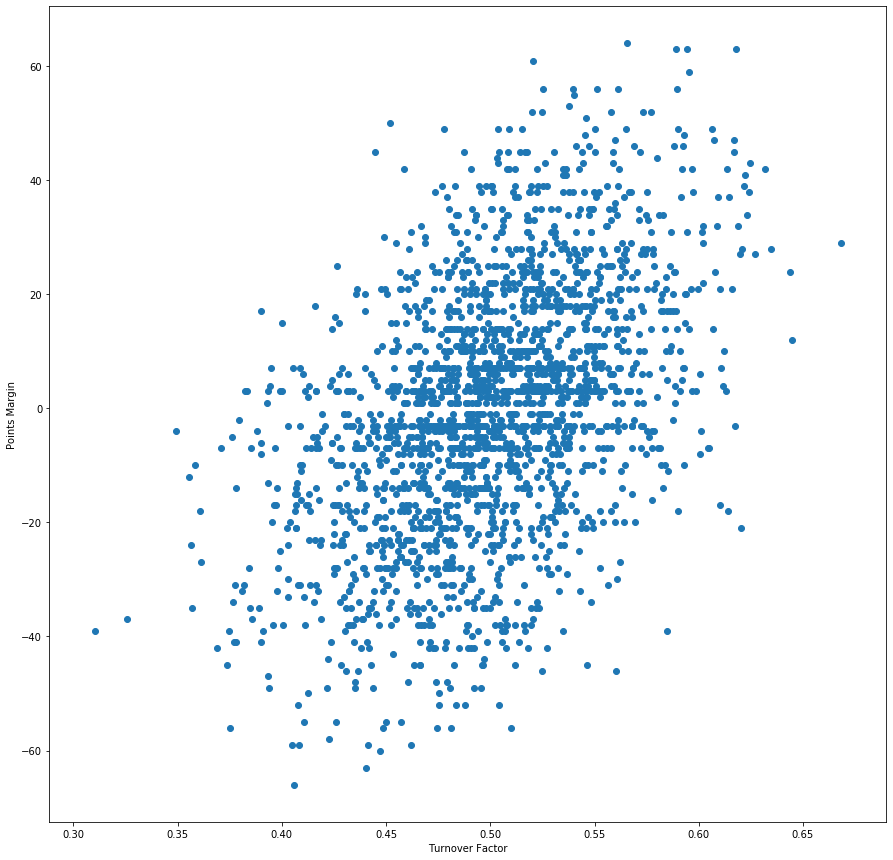

In [30]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

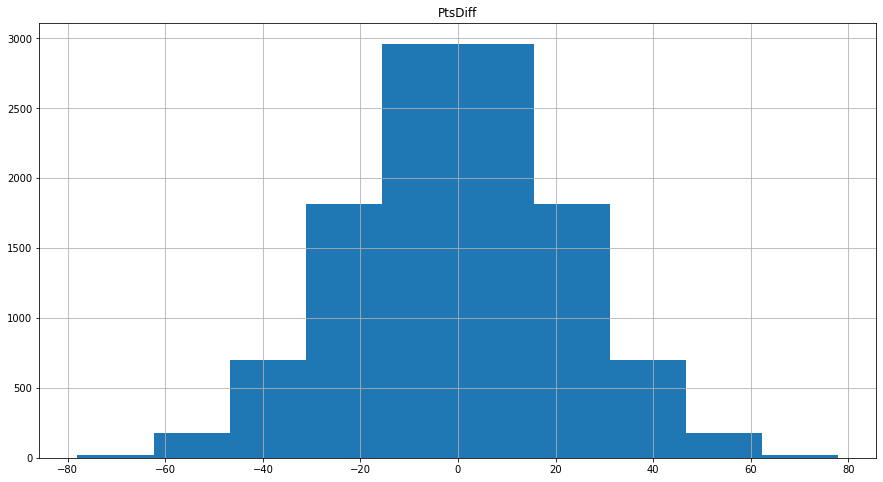

In [31]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

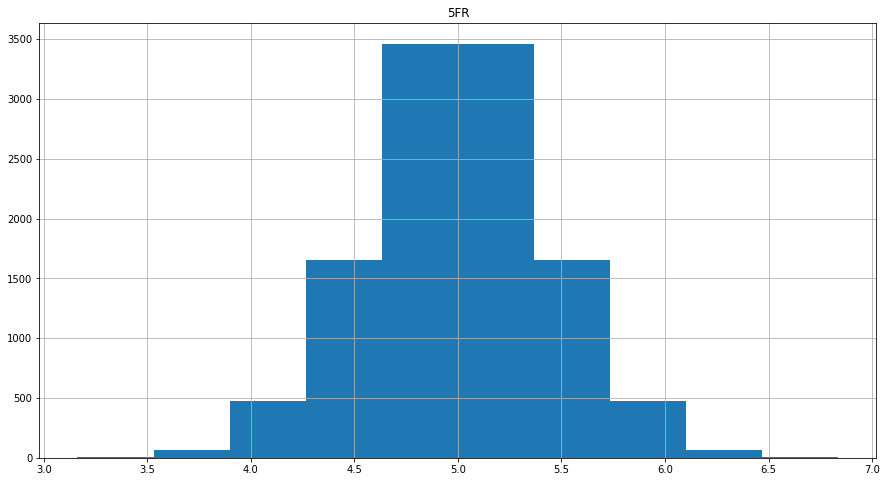

In [32]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

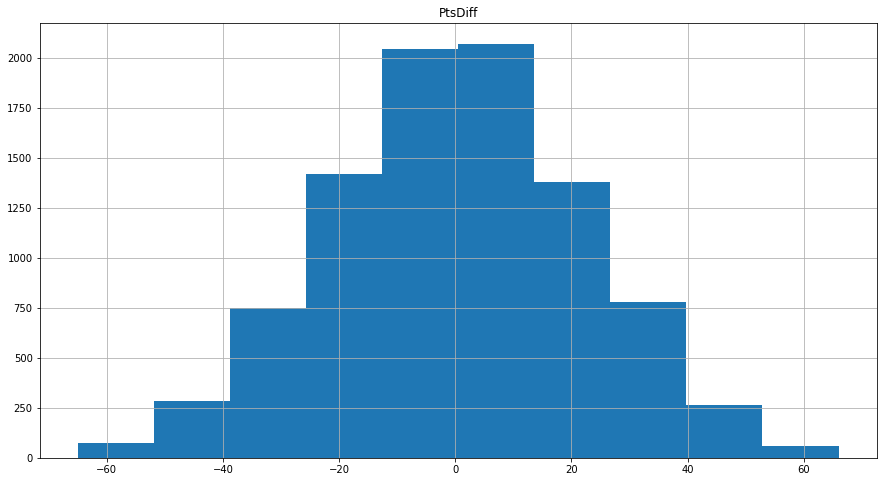

In [33]:
train_data.hist(column='PtsDiff', figsize=(15,8));

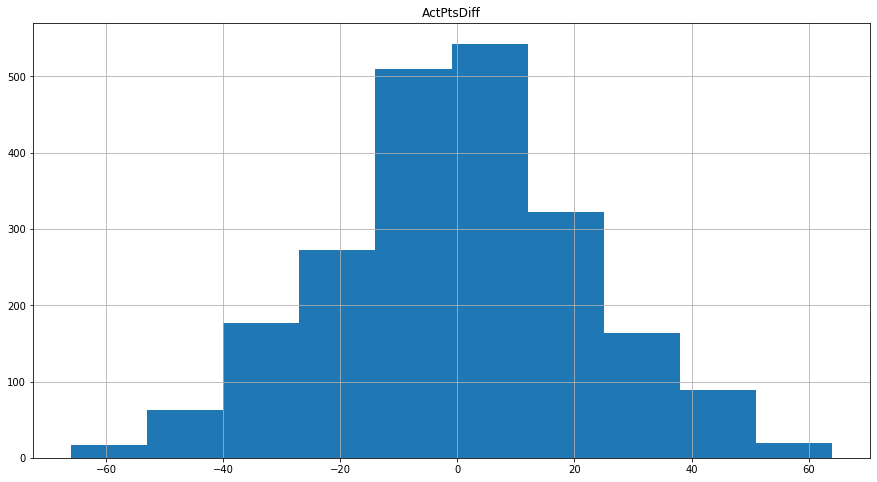

In [34]:
test.hist(column='ActPtsDiff', figsize=(15,8));

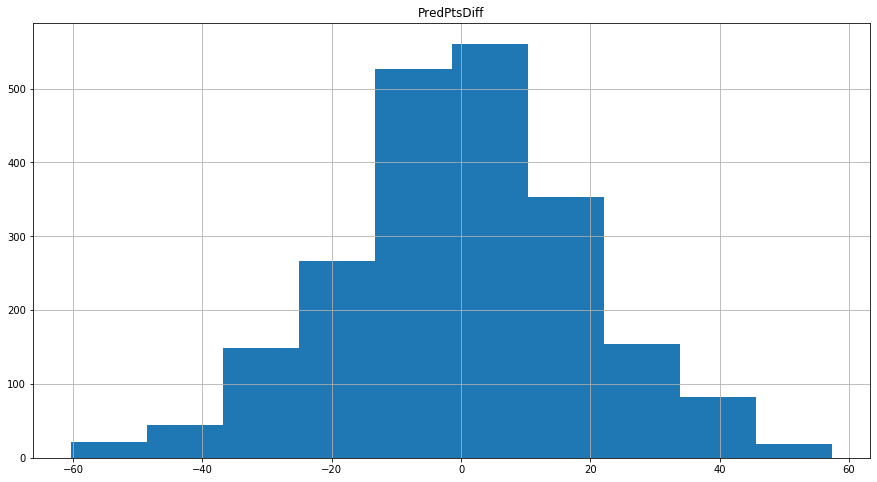

In [35]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [36]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [37]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -4.0 (exact value: -3.5117449606840436)
Z score: -0.18412038682236284
Win Prob for Virginia Tech: 42.70%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0       Virginia    2018  401013183  31.0     -3.0        0.875665  0.396825   
1  Virginia Tech    2018  401013183  34.0      3.0        0.124335  0.368421   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.111111  6.507937  0.930578  ...    0.124959      -0.040309     -0.002715   
1  0.078947  5.513158  0.805619  ...   -0.124959       0.040309      0.002715   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0            0.0                  0.0    0.119048          0.119048   
1            0.0                  0.0   -0.119048         -0.119048   

   FGEffDiff       5FR   5FRDiff  
0   0.333333  5.070568  0.141137  
1  -0.333333  4.929432 -0.141137  

[2 rows x 53 columns]

In [38]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -13.0 (exact value: -12.535241263901076)
Z score: -0.6566614527630661
Win Prob for Georgia Tech: 25.57%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0  Georgia Tech    2019  401112488  28.0      7.0        0.065752  0.396825   
1         Miami    2019  401112488  21.0     -7.0        0.934248  0.370968   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.111111  5.460317  0.894136  ...   -0.121075       0.018689      0.000768   
1  0.112903  5.790323  1.015211  ...    0.121075      -0.018689     -0.000768   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0            0.0                 0.25         0.0               0.0   
1            0.0                -0.25         0.0               0.0   

   FGEffDiff       5FR   5FRDiff  
0        0.0  4.750502 -0.498995  
1        0.0  5.249498  0.498995  

[2 rows x 53 columns]

In [39]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -1.0 (exact value: -0.5891461161519286)
Z score: -0.031070180238922915
Win Prob for Georgia Tech: 48.76%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0      NC State    2019  401112513  26.0     -2.0        0.156447  0.487500   
1  Georgia Tech    2019  401112513  28.0      2.0        0.843553  0.473684   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.150000  5.712500  0.704891  ...   -0.300725       0.012719           0.0   
1  0.140351  7.035088  1.005617  ...    0.300725      -0.012719           0.0   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0       0.066667             0.166667         0.0               0.0   
1      -0.066667            -0.166667         0.0               0.0   

   FGEffDiff       5FR   5FRDiff  
0        1.0  5.012615  0.025231  
1       -1.0  4.987385 -0.025231  

[2 rows x 53 columns]

In [40]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 4.0 (exact value: 3.967680239447286)
Z score: 0.20756100118172652
Win Prob for Mississippi State: 58.22%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb  \
0           Ole Miss    2019  401110863  20.0     -1.0        0.384124   
1  Mississippi State    2019  401110863  21.0      1.0        0.615876   

      OffSR     OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  \
0  0.422535  0.070423  5.563380  0.880173  ...    0.092249       0.000243   
1  0.413793  0.137931  5.482759  0.787924  ...   -0.092249      -0.000243   

   SackRateDiff  KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  \
0     -0.004614      -0.666667            -0.083333        -0.2   
1      0.004614       0.666667             0.083333         0.2   

   PuntReturnSRDiff  FGEffDiff       5FR   5FRDiff  
0              -0.2          0  4.922257 -0.155486  
1               0.2          0  5.077743  0.155486  

[2 rows x 53 columns]

In [41]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -5.0 (exact value: -5.498478476884057)
Z score: -0.28816134189546155
Win Prob for Texas A&M: 38.66%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0        LSU    2018  401012356  72.0     -2.0        0.321374  0.466667   
1  Texas A&M    2018  401012356  74.0      2.0        0.678626  0.423077   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.088889  5.511111  0.682602  ...   -0.349878       0.001282     -0.047436   
1  0.105769  4.634615  1.032480  ...    0.349878      -0.001282      0.047436   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0            0.2                 -0.2       -0.25             -0.25   
1           -0.2                  0.2        0.25              0.25   

   FGEffDiff       5FR   5FRDiff  
0      -0.25  5.109964  0.219927  
1       0.25  4.890036 -0.219927  

[2 rows x 53 columns]

In [42]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

team  avg_win_prob  games  proj_wins  proj_losses
1           Clemson      0.943619     13       12.0          1.0
2        Ohio State      0.941848     13       12.0          1.0
3               LSU      0.921403     13       12.0          1.0
4           Alabama      0.915825     12       11.0          1.0
5         Wisconsin      0.886328     13       12.0          1.0
..              ...           ...    ...        ...          ...
126     Connecticut      0.104040     12        1.0         11.0
127         Rutgers      0.088470     12        1.0         11.0
128           Akron      0.082482     12        1.0         11.0
129           UMass      0.057655     12        1.0         11.0
130  San José State      0.000000     12        0.0         12.0

[130 rows x 5 columns]

In [43]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

team  second_order_wins  second_order_losses
77       Ohio State          11.576937             1.423063
21          Clemson          10.653438             2.346562
53              LSU          10.457101             2.542899
128       Wisconsin           9.768699             3.231301
78         Oklahoma           9.545687             3.454313
..              ...                ...                  ...
103     Texas State           2.119782             9.880218
25      Connecticut           1.903057            10.096943
1             Akron           1.818801            10.181199
112           UMass           1.381526            10.618474
90   San José State           0.000000            12.000000

[130 rows x 3 columns]

In [44]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

Team  Season       5FR  Rank
0           Alabama    2012  5.557889     1
1     Florida State    2012  5.454605     2
2               BYU    2012  5.335653     3
3     Arizona State    2012  5.333539     4
4          Oklahoma    2012  5.331083     5
...             ...     ...       ...   ...
1025  Bowling Green    2019  4.525809   126
1026    Connecticut    2019  4.506369   127
1027        Rutgers    2019  4.450434   128
1028          Akron    2019  4.402725   129
1029          UMass    2019  4.380957   130

[1030 rows x 4 columns]

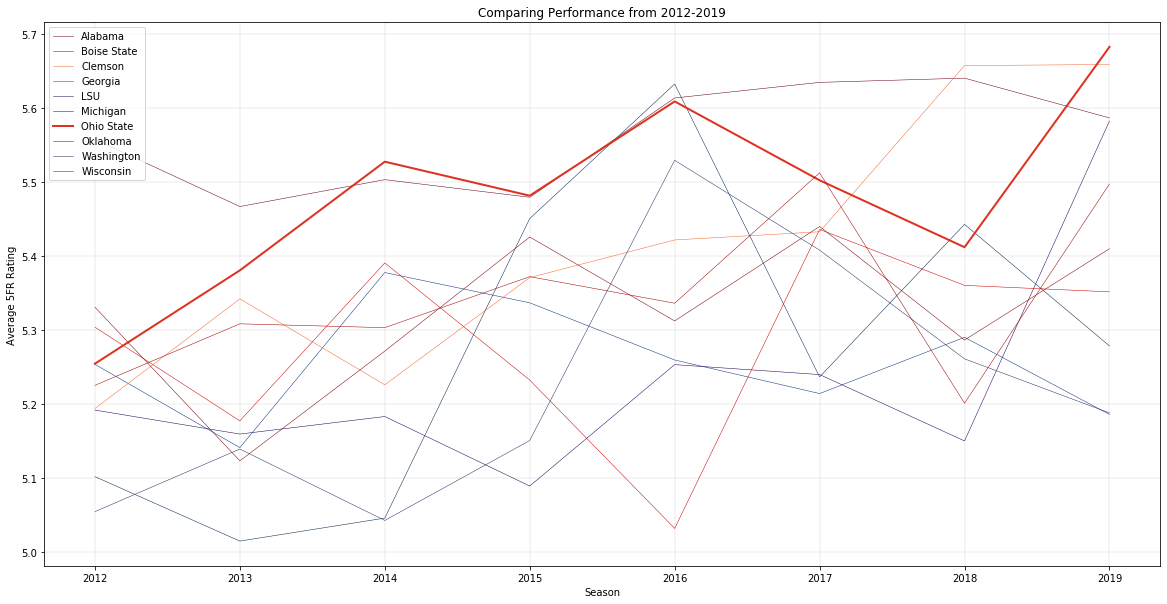

In [45]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [46]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

Team    Avg5FR
0             Alabama  5.560512
1          Ohio State  5.481456
2             Clemson  5.413149
3           Wisconsin  5.344711
4            Oklahoma  5.325188
..                ...       ...
125     Georgia State  4.706279
126             UMass  4.678491
127  New Mexico State  4.678160
128  Coastal Carolina  4.621592
129            Kansas  4.588694

[130 rows x 2 columns]

In [47]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

Team  Season       5FR  Rank
900     Ohio State    2019  5.682812     1
127  Florida State    2013  5.667090     1
901        Clemson    2019  5.659044     2
770        Clemson    2018  5.657551     1
771        Alabama    2018  5.640608     2
640        Alabama    2017  5.634880     1
512       Michigan    2016  5.632687     1
513        Alabama    2016  5.613788     2
514     Ohio State    2016  5.609128     3
902        Alabama    2019  5.586845     3

In [48]:
strength_max[strength_max.Team == "Georgia Tech"]

Team  Season       5FR  Rank
280   Georgia Tech    2014  5.189151    25
65    Georgia Tech    2012  5.002690    66
194   Georgia Tech    2013  4.998730    68
844   Georgia Tech    2018  4.984770    75
727   Georgia Tech    2017  4.918923    88
592   Georgia Tech    2016  4.894851    81
473   Georgia Tech    2015  4.827962    90
1018  Georgia Tech    2019  4.620667   119

In [49]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

GameID        Opponent  Season       Team  Week
0      322520130.0        Michigan  2012.0  Air Force   1.0
1      322662439.0            UNLV  2012.0  Air Force   2.0
2      322732005.0  Colorado State  2012.0  Air Force   3.0
3      322802005.0            Navy  2012.0  Air Force   4.0
4      322872751.0         Wyoming  2012.0  Air Force   5.0
...            ...             ...     ...        ...   ...
11248  401117533.0          Nevada  2019.0    Wyoming   7.0
11249  401117541.0     Boise State  2019.0    Wyoming   8.0
11250  401117546.0      Utah State  2019.0    Wyoming   9.0
11251  401117550.0  Colorado State  2019.0    Wyoming  10.0
11252  401117556.0       Air Force  2019.0    Wyoming  11.0

[11253 rows x 5 columns]

In [50]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4, adjust_hfa = False):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week) & (opponent_game_ids.Season == year)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week) & (opponent_game_ids.Season == year)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    
    proj_MOV = pred[0]
    if (adjust_hfa):
        proj_MOV += 2.5
    z = (proj_MOV - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, proj_MOV]

predict_matchup('Georgia Tech', 'Clemson', 2019, 0, -1)

[0.12871534433757248, -21.621414188891706]

In [51]:
team_triples = [
    ['Buffalo', 'Charlotte', 7, 24], # Buff 31, Char 9
    ['Utah State', 'Kent State', 7, -10], # Kent 51, Utah 41
    ['San Diego State', 'Central Michigan', 3.5, 37], # SDSU 48, CMU 11
    ['Georgia Southern','Liberty', 4.5, -7], # Lib 23, GASO 16
    ['SMU','Florida Atlantic', 7, -14], # FAU 52, SMU 28
    ['Florida International','Arkansas State', 1, -6], # ArkSt 34, FIU 28
    ['Washington', 'Boise State', 3.5, 31], # Wash 38, Boise 7
    ['Appalachian State', 'UAB', 17, 14], # App 31, UAB 17
    ['UCF','Marshall',15,23], # UCF 48, Marshall 25
    ['BYU',"Hawai'i",2,-4], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
    ['Miami','Louisiana Tech',6,-14], # LaTech 14, Miami 0
    ['Pittsburgh','Eastern Michigan',11, 4], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
    ['North Carolina','Temple',5, 42], # UNC 55, Temple 13
    ['Michigan State','Wake Forest',3.5,6], # MichSt 27, Wake 21
    ['Texas A&M', 'Oklahoma State', 7, 3], # TAMU 24, OKST 21
    ['Iowa', 'USC', 2.5, 24], # Iowa 48, USC 24
    ['Air Force', 'Washington State', 3, 10], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
    ['Penn State','Memphis',7,14], # Cotton Bowl - PennSt 53, Memphis 39
    ['Notre Dame', 'Iowa State', 4, 24], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
    ['LSU','Oklahoma',11, 35], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
    ['Clemson','Ohio State',2.5, 6], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
    ['Western Kentucky', 'Western Michigan', 3.5, 3], # WKU 23, WMU 20
    ['Mississippi State', 'Louisville', 4, -10], # LOU 38, MSST 28
    ['California', 'Illinois', 6.5, 15], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
    ['Florida','Virginia',14, 8], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
    ['Virginia Tech', 'Kentucky', 3, -7], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
    ['Arizona State', 'Florida State', 4, 6], # ASU 20, FSU 14
#    ----- 19-8 SU / 14-13 ATS ------  
    ['Navy', 'Kansas State', 2, 3], # Navy 20, Kansas St 17
#    ----- 20-8 SU / 15-13 ATS ------  
    ['Wyoming', 'Georgia State', 7, 21], # Wyoming 38, GAST 17
#    ----- 21-8 SU / 15-14 ATS ------  
    ['Utah', 'Texas', 7, -18], # Texas 38, Utah 10
#    ----- 21-9 SU / 16-14 ATS ------     
    ['Auburn', 'Minnesota', 7.5, -7], # Minnesota 31, Auburn 24
    ['Alabama', 'Michigan', 7, 19], # Bama 35, Mich 16
#    ----- 23-9 SU / 17-15 ATS ------    
    ['Wisconsin','Oregon',2.5, -1], # Rose Bowl - Oregon 28, Wisc 27
#    ----- 23-10 SU / 18-15 ATS ------  
    ['Georgia','Baylor',7.5, 12], # Sugar Bowl - uga 26, Baylor 14
#    ----- 23-11 SU / 18-16 ATS ------      
    ['Cincinnati', 'Boston College',7, 32], # Cincy 38, BC 6
#    ----- 23-12 SU / 18-17 ATS ------    
    ['Tennessee', 'Indiana', 1.5, 1], # Tennessee 23, Indiana 22
#    ----- 23-13 SU / 19-17 ATS ------        
    ['Ohio', 'Nevada', 7.5, 8], # Ohio 30, Nevada 21
#    ----- 24-13 SU / 19-18 ATS ------     
    ['Tulane', 'Southern Mississippi', 7, 17], # Tulane 30, Southern Miss 13
#    ----- 24-14 SU / 19-19 ATS ------     
    ['Louisiana', 'Miami (OH)', 14, 10], # Louisiana 27, Miami 17
#    ----- 24-15 SU / 19-20 ATS ------  
    ["LSU", "Clemson", 6, 17]
#    ----- 24-16 SU / 19-21 ATS ------  
]

def determine_ml_base_win(row):
    winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

def determine_ats_base_win(row):
    mov = row.home_point_diff
    if (row.spread > 0):
        if (mov == row.spread):
            return "Push"
        winner = row.favorite if (mov > row.spread) else row.opponent
    elif (row.spread < 0):
        if (mov == row.spread):
            return "Push"
        winner = row.opponent if (mov < row.spread) else row.favorite
    else:
        winner = row.favorite if (row.home_point_diff > 0) else row.opponent
    return winner

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    point_diff = data[3]
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "home_point_diff" : [point_diff],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
bets['ml_win'] = bets.apply(lambda x: determine_ml_base_win(x), axis=1) 
bets['ats_win'] = bets.apply(lambda x: determine_ats_base_win(x), axis=1) 
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

favorite              opponent  spread  home_point_diff  \
0                Buffalo             Charlotte     7.0               24   
0             Utah State            Kent State     7.0              -10   
0        San Diego State      Central Michigan     3.5               37   
0       Georgia Southern               Liberty     4.5               -7   
0                    SMU      Florida Atlantic     7.0              -14   
0  Florida International        Arkansas State     1.0               -6   
0             Washington           Boise State     3.5               31   
0      Appalachian State                   UAB    17.0               14   
0                    UCF              Marshall    15.0               23   
0                    BYU               Hawai'i     2.0               -4   
0                  Miami        Louisiana Tech     6.0              -14   
0             Pittsburgh      Eastern Michigan    11.0                4   
0         North Carolina                Temple     5.0               42   
0         Michigan State           Wake Forest     3.5                6   
0              Texas A&M        Oklahoma State     7.0                3   
0                   Iowa                   USC     2.5               24   
0              Air Force      Washington State     3.0               10   
0             Penn State               Memphis     7.0               14   
0             Notre Dame            Iowa State     4.0               24   
0                    LSU              Oklahoma    11.0               35   
0                Clemson            Ohio State     2.5                6   
0       Western Kentucky      Western Michigan     3.5                3   
0      Mississippi State            Louisville     4.0              -10   
0             California              Illinois     6.5               15   
0                Florida              Virginia    14.0                8   
0          Virginia Tech              Kentucky     3.0               -7   
0          Arizona State         Florida State     4.0                6   
0                   Navy          Kansas State     2.0                3   
0                Wyoming         Georgia State     7.0               21   
0                   Utah                 Texas     7.0              -18   
0                 Auburn             Minnesota     7.5               -7   
0                Alabama              Michigan     7.0               19   
0              Wisconsin                Oregon     2.5               -1   
0                Georgia                Baylor     7.5               12   
0             Cincinnati        Boston College     7.0               32   
0              Tennessee               Indiana     1.5                1   
0                   Ohio                Nevada     7.5                8   
0                 Tulane  Southern Mississippi     7.0               17   
0              Louisiana            Miami (OH)    14.0               10   
0                    LSU               Clemson     6.0               17   

    proj_MOV  proj_win_prob  proj_cover_status            ml_pick  \
0   2.633644       0.554761              False            Buffalo   
0   2.985331       0.562030              False         Utah State   
0  -7.070409       0.355512              False   Central Michigan   
0   0.318702       0.506571              False   Georgia Southern   
0 -11.271577       0.277432              False   Florida Atlantic   
0  -7.594981       0.345333              False     Arkansas State   
0   2.498871       0.551971              False         Washington   
0  10.391545       0.706767              False  Appalachian State   
0   0.692843       0.514385              False                UCF   
0   3.368979       0.569935               True                BYU   
0  12.092044       0.736639               True              Miami   
0   7.289766       0.648596              False         Pittsburgh   
0   0.342058       0.507059              Fa

In [52]:
print(f"ATS Record: {len(bets[bets.ats_pick == bets.ats_win])}-{len(bets[bets.ats_pick != bets.ats_win])}")
print(f"ML Record: {len(bets[bets.ml_pick == bets.ml_win])}-{len(bets[bets.ml_pick != bets.ml_win])}")

ATS Record: 19-21
ML Record: 24-16


In [53]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 0.0 (exact value: 0.35474841673495017)
Z score: 0.018359543420070644
Win Prob for Virginia: 50.73%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0  Virginia Tech    2019  401112521  30.0     -9.0        0.577256  0.432432   
1       Virginia    2019  401112521  39.0      9.0        0.422744  0.381818   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.162162  6.540541  1.169095  ...   -0.403644      -0.089435     -0.044717   
1  0.181818  8.872727  1.572739  ...    0.403644       0.089435      0.044717   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0           0.25            -0.232143    0.333333          0.333333   
1          -0.25             0.232143   -0.333333         -0.333333   

   FGEffDiff       5FR   5FRDiff  
0        0.0  4.993899 -0.012203  
1        0.0  5.006101  0.012203  

[2 rows x 53 columns]

In [54]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 12.0 (exact value: 11.732929148772755)
Z score: 0.6142103612085419
Win Prob for North Carolina: 73.05%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0  North Carolina    2019  401112475  38.0     16.0         0.98905  0.457447   
1    Georgia Tech    2019  401112475  22.0    -16.0         0.01095  0.396226   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.106383  5.744681  0.811309  ...   -0.235394       0.079888      0.037736   
1  0.150943  6.094340  1.046703  ...    0.235394      -0.079888     -0.037736   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0       0.238095             0.095238   -0.214286         -0.214286   
1      -0.238095            -0.095238    0.214286          0.214286   

   FGEffDiff       5FR   5FRDiff  
0        0.5  5.231722  0.463445  
1       -0.5  4.768278 -0.463445  

[2 rows x 53 columns]

In [55]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 21.0 (exact value: 21.19369698887331)
Z score: 1.1096503957087824
Win Prob for Pittsburgh: 86.64%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0    Pittsburgh    2019  401112498  20.0     10.0        0.970074  0.362319   
1  Georgia Tech    2019  401112498  10.0    -10.0        0.029926  0.204082   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.057971  5.086957  0.882151  ...   -0.248736       0.038746      0.026324   
1  0.061224  3.591837  1.130888  ...    0.248736      -0.038746     -0.026324   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0            0.0                 -1.0       -0.25             -0.25   
1            0.0                  1.0        0.25              0.25   

   FGEffDiff       5FR   5FRDiff  
0   0.166667  5.419322  0.838645  
1  -0.166667  4.580678 -0.838645  

[2 rows x 53 columns]

In [56]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -11.0 (exact value: -10.720495420974444)
Z score: -0.5616271216998082
Win Prob for Auburn: 28.72%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0  Alabama    2019  401110865  45.0     -3.0        0.400109  0.453333   
1   Auburn    2019  401110865  48.0      3.0        0.599891  0.338710   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.133333  6.440000  0.905516  ...   -0.083465      -0.033763     -0.013333   
1  0.112903  5.322581  0.988981  ...    0.083465       0.033763      0.013333   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0      -0.321429            -0.196429   -0.333333         -0.333333   
1       0.321429             0.196429    0.333333          0.333333   

   FGEffDiff       5FR   5FRDiff  
0       -0.5  5.213512  0.427025  
1        0.5  4.786488 -0.427025  

[2 rows x 53 columns]

In [57]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 38.0 (exact value: 37.989609916723154)
Z score: 1.9892161794886034
Win Prob for Georgia: 97.67%
---


Team  Season     GameID   Pts  PtsDiff  CfbDataWinProb     OffSR  \
0       Georgia    2019  401110867  52.0     45.0        0.998507  0.472222   
1  Georgia Tech    2019  401110867   7.0    -45.0        0.001493  0.224138   

      OffER       YPP    IsoPPP  ...  IsoPPPDiff  HavocRateDiff  SackRateDiff  \
0  0.138889  6.847222  0.969971  ...    0.455922       0.020115      0.003352   
1  0.034483  2.396552  0.514049  ...   -0.455922      -0.020115     -0.003352   

   KickoffSRDiff  KickoffReturnSRDiff  PuntSRDiff  PuntReturnSRDiff  \
0       0.888889            -0.888889    0.615385          0.615385   
1      -0.888889             0.888889   -0.615385         -0.615385   

   FGEffDiff       5FR   5FRDiff  
0        0.5  5.752373  1.504745  
1       -0.5  4.247627 -1.504745  

[2 rows x 53 columns]

In [58]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 24.0 (exact value: 24.065493531529334)
Z score: 1.2600401951646425
Win Prob for Clemson: 89.62%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 11.0 (exact value: 10.60412127651058)
Z score: 0.5550971242461844
Win Prob for Georgia Tech: 71.06%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -12.0 (exact value: -11.640466374574368)
Z score: -0.6098040190398788
Win Prob for The Citadel: 27.10%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 23.0 (exact value: 23.21161548457029)
Z score: 1.215324440989674
Win Prob for Temple: 88.79%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 12.0 (exact value: 11.732929148772755)
Z score: 0.6142103612085

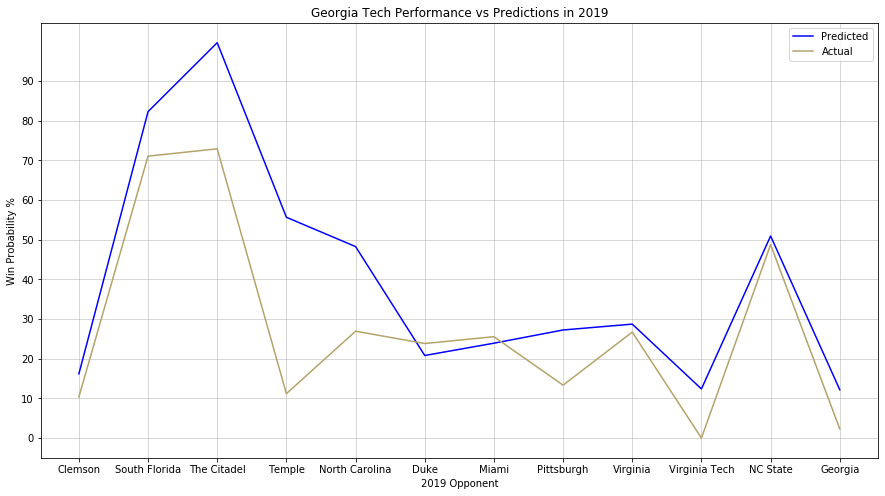

In [59]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

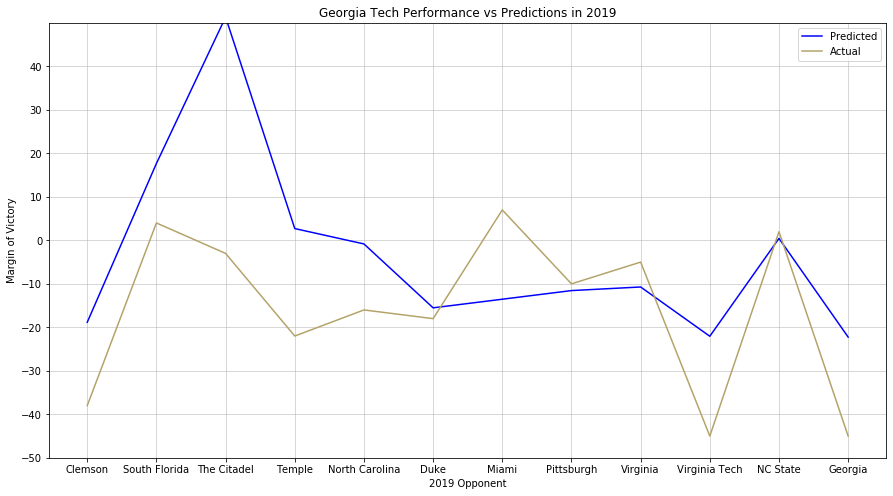

In [60]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 45.0 (exact value: 44.61699816169787)
Z score: 2.3362782273299407
Win Prob for Georgia Tech: 99.03%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 9.0 (exact value: 9.234583198205861)
Z score: 0.4833773648955024
Win Prob for South Florida: 68.56%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 8.0 (exact value: 8.000149421263451)
Z score: 0.41873272680975165
Win Prob for Pittsburgh: 66.23%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 39.0 (exact value: 38.61151683452614)
Z score: 2.02178410526586
Win Prob for Clemson: 97.84%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 43.0 (exact value: 42.73215739168258)
Z score: 

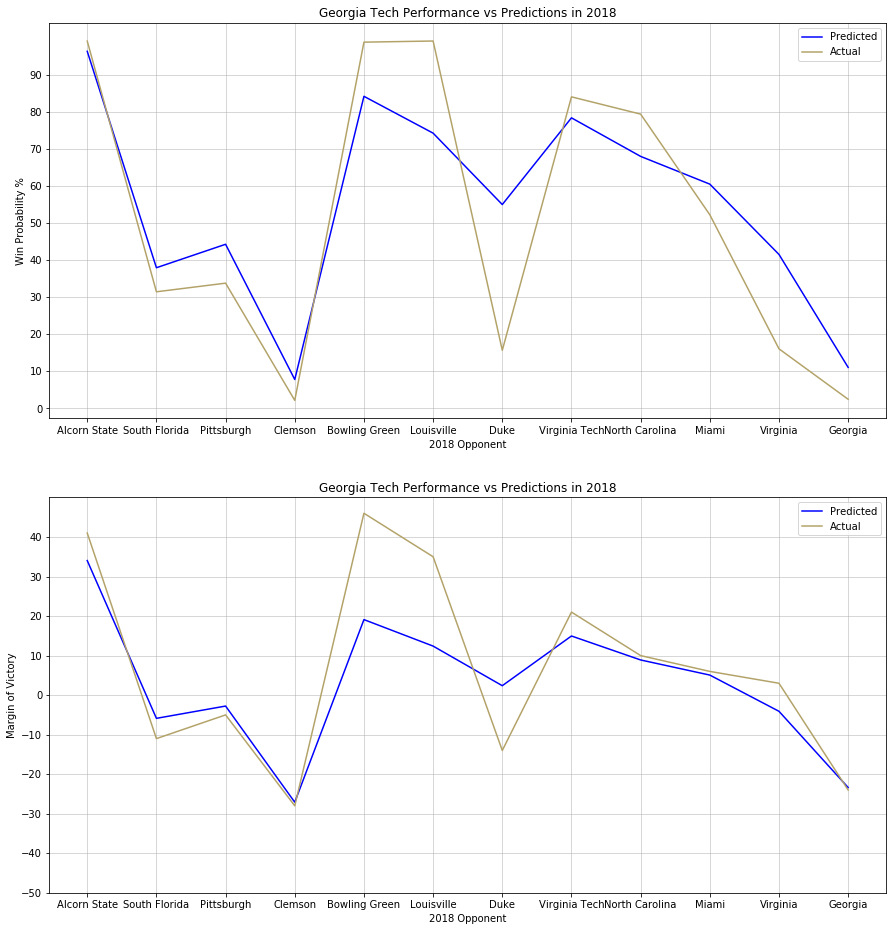

In [61]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

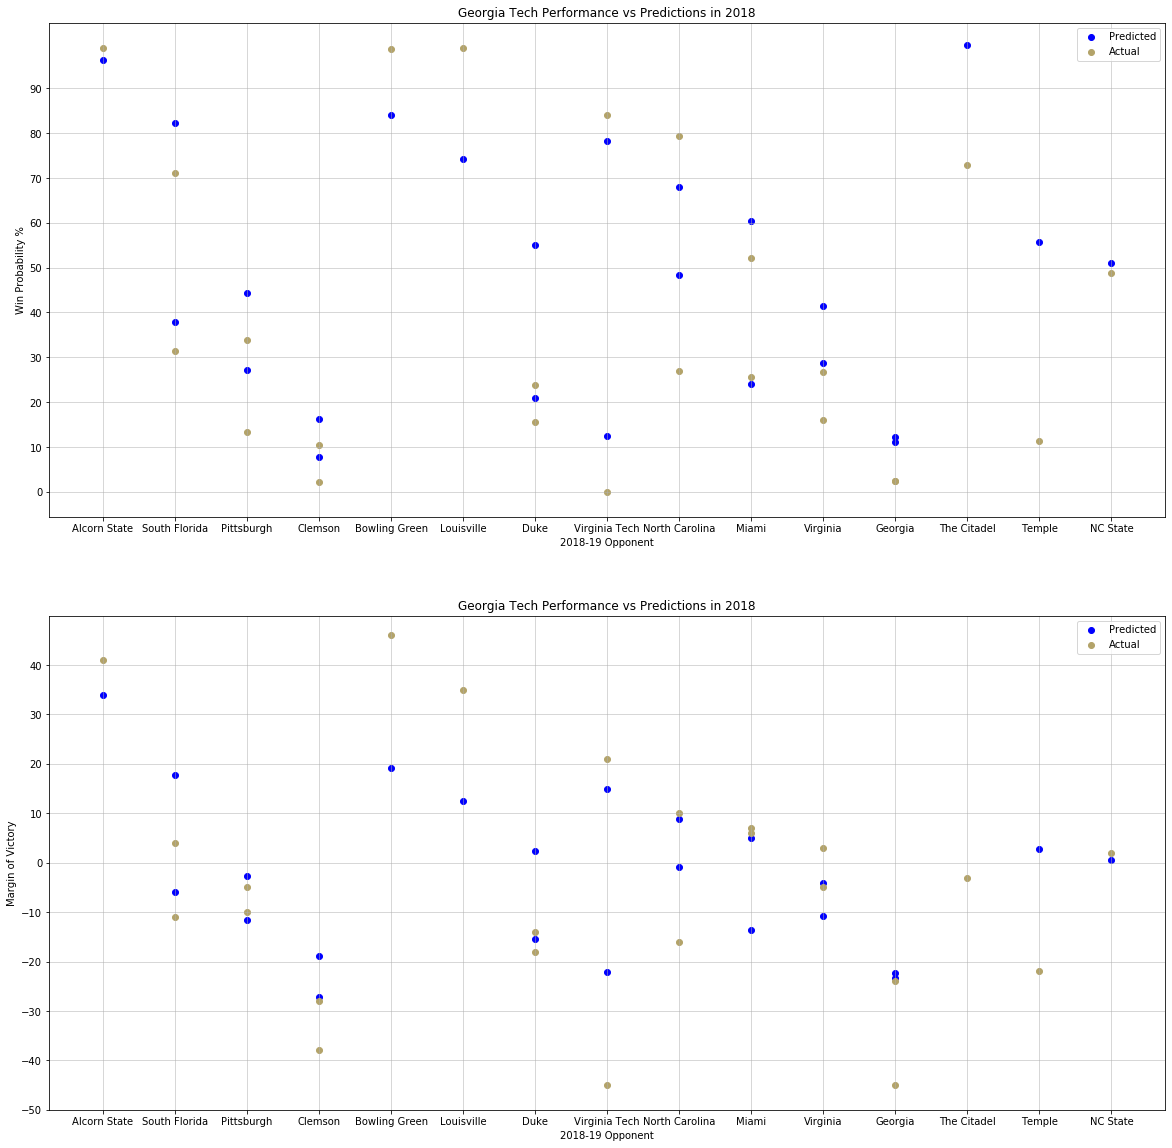

In [62]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [63]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season      2012      2013      2014      2015      2016      2017      2018  \
Season                                                                         
2012    1.000000  0.588419  0.525922  0.451708  0.382888  0.294932  0.300102   
2013    0.588419  1.000000  0.562660  0.366535  0.245886  0.260429  0.185906   
2014    0.525922  0.562660  1.000000  0.616191  0.486516  0.332863  0.332074   
2015    0.451708  0.366535  0.616191  1.000000  0.656791  0.472449  0.379352   
2016    0.382888  0.245886  0.486516  0.656791  1.000000  0.602822  0.417091   
2017    0.294932  0.260429  0.332863  0.472449  0.602822  1.000000  0.634953   
2018    0.300102  0.185906  0.332074  0.379352  0.417091  0.634953  1.000000   
2019    0.363724  0.279529  0.386088  0.403569  0.594267  0.569375  0.610008   

Season      2019  
Season            
2012    0.363724  
2013    0.279529  
2014    0.386088  
2015    0.403569  
2016    0.594267  
2017    0.569375  
2018    0.610008  
2019    1.000000

In [64]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1,(row.Site == "Home"))[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1, (row.Site == "Home"))[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["Clemson","Gardner-Webb","UCF","North Carolina","Virginia Tech","Virginia","Pittsburgh","Syracuse","Duke","Notre Dame","Miami","Georgia"],
    "Site" : ["Home","Home","Home","Away","Away","Home","Away","Away","Home","Neutral","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("Georgia Tech", opp_2020_df, 2020)
georgia_tech_2020

Year          Team        Opponent     Site  PredWinProb    PredMOV
0   2020  Georgia Tech         Clemson     Home    15.827683 -19.121414
1   2020  Georgia Tech    Gardner-Webb     Home    98.100504  39.627012
2   2020  Georgia Tech             UCF     Home    35.916813  -6.883334
3   2020  Georgia Tech  North Carolina     Away    31.493915  -9.198016
4   2020  Georgia Tech   Virginia Tech     Away    28.488108 -10.849863
5   2020  Georgia Tech        Virginia     Home    31.081313  -9.420455
6   2020  Georgia Tech      Pittsburgh     Away    31.378021  -9.260369
7   2020  Georgia Tech        Syracuse     Away    42.178632  -3.763910
8   2020  Georgia Tech            Duke     Home    43.765654  -2.992209
9   2020  Georgia Tech      Notre Dame  Neutral    24.826815 -12.979947
10  2020  Georgia Tech           Miami     Home    32.707602  -8.550738
11  2020  Georgia Tech         Georgia     Away    16.222363 -18.811966

In [65]:
generate_win_prob(401135288, 2019)
box2 = calculate_box_score(401135288, 2019)
# testDiffs = ["Team",'5FRDiff']
# print(box2[["Team","FP","FPDiff"]])
break_down_box_score(box2)

Could not find basic game data for game_id 401135288 locally, checking CFB Data API
Could not find drive data for game_id 401135288 locally, checking CFB Data API
Could not find play by play data for game_id 401135288 locally, checking CFB Data API
Game: Oregon @ Wisconsin
Actual Winner: Oregon
MOV: Oregon by 1
Proj MOV: Oregon by 5.0 (exact value: 4.549284228791546)
Z score: 0.23801834940296088
Win Prob for Oregon: 59.41%
---
Could not find basic game data for game_id 401135288 locally, checking CFB Data API
Could not find drive data for game_id 401135288 locally, checking CFB Data API
Could not find play by play data for game_id 401135288 locally, checking CFB Data API


Team       Eff      Expl   FinDrv    FldPos   Trnovr       5FR  \
0     Oregon  5.114379  4.961943  4.87236  5.115385  5.68268  5.089276   
1  Wisconsin  4.885621  5.038057  5.12764  4.884615  4.31732  4.910724   

    5FRDiff  
0  0.178552  
1 -0.178552

In [66]:
predict_matchup("Oregon","Wisconsin", 2012, -1)

[0.3906438177810998, -5.29759327976813]

In [67]:
line_data = pd.DataFrame()

for i in range(2013, 2020):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")

Spreads imported: 17274


In [68]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite))[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week, games_to_consider = 4, adjust_hfa = ~(row.NeutralSite))[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    selected_games = games[(games.id.isin(lines.id))]
    lines = pd.merge(lines, selected_games[['id','neutral_site']], on="id")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam,"AwayScore": lines.awayScore,"NeutralSite":lines.neutral_site,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [69]:
historic_validation = pd.DataFrame()
for i in range(2013, 2020):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 700 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 692 games with betting lines for 2013 season.
[Simulation] Creating projections for 692 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 697 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 648 games with betting lines for 2014 season.
[Simulation] Creating projections for 648 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 709 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 675 games with betting lines for 2015 season.
[Simulation] Creating projections for 675 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

pick_category  season    W    L   D    WinPct
0            ML    2013  543  149   0  0.784682
1           ATS    2013  404  280   8  0.583815
0            ML    2014  508  140   0  0.783951
1           ATS    2014  409  223  16  0.631173
0            ML    2015  535  140   0  0.792593
1           ATS    2015  423  234  18  0.626667
0            ML    2016  528  148   0  0.781065
1           ATS    2016  421  237  18  0.622781
0            ML    2017  567  153   0  0.787500
1           ATS    2017  434  266  20  0.602778
0            ML    2018  528  142   0  0.788060
1           ATS    2018  395  258  17  0.589552
0            ML    2019  598  134   0  0.816940
1           ATS    2019  440  281  11  0.601093

In [70]:
def generate_weekly_payout(x, bet_cash):
    avg_games = (x.W + x.L + x.D) / max(games[(games.season == x.season)].week)
    wins = avg_games * x.WinPct
    losses = avg_games * (1 - x.WinPct - verify_division(x.D, (x.W + x.L + x.D)))
    payout = (bet_cash * wins) - ((bet_amount * 1.1) * losses)
    return payout

ats_payout = historic_validation[(historic_validation.pick_category == "ATS")].copy()
bet_amount = 5
ats_payout['total_invested'] = ats_payout.apply(lambda x: bet_amount * (x.W + x.L + x.D), axis=1)
ats_payout['net_payout'] = ats_payout.apply(lambda x: (bet_amount * x.W) - ((bet_amount * 1.1) * x.L), axis=1)
ats_payout['avg_weekly_payout'] = ats_payout.apply(lambda x: generate_weekly_payout(x, bet_amount), axis=1)
ats_payout['pct_return'] = ats_payout.apply(lambda x: (x.net_payout / x.total_invested), axis=1)
print(f"Total earnings (2013-2019) if betting ${bet_amount} per game: ${sum(round(ats_payout.net_payout))}")
ats_payout

Total earnings (2013-2019) if betting $5 per game: $4845.0


pick_category  season    W    L   D    WinPct  total_invested  net_payout  \
1           ATS    2013  404  280   8  0.583815            3460       480.0   
1           ATS    2014  409  223  16  0.631173            3240       818.5   
1           ATS    2015  423  234  18  0.626667            3375       828.0   
1           ATS    2016  421  237  18  0.622781            3380       801.5   
1           ATS    2017  434  266  20  0.602778            3600       707.0   
1           ATS    2018  395  258  17  0.589552            3350       556.0   
1           ATS    2019  440  281  11  0.601093            3660       654.5   

   avg_weekly_payout  pct_return  
1          30.000000    0.138728  
1          51.156250    0.252623  
1          55.200000    0.245333  
1          53.433333    0.237130  
1          47.133333    0.196389  
1          37.066667    0.165970  
1          43.633333    0.178825

In [71]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.790684281680245
Avg ATS Win %: 0.6082655018459918


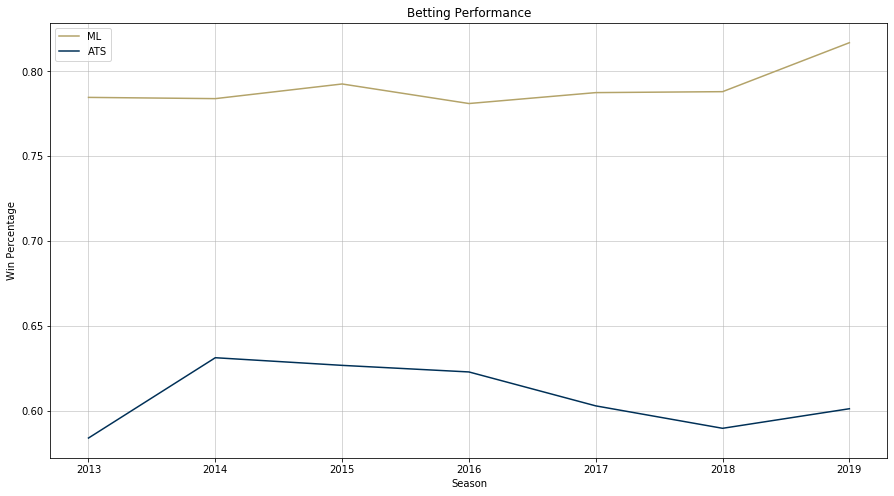

In [72]:
f, a = plt.subplots(1, figsize=(15, 8))
a.plot(historic_validation[(historic_validation.pick_category == "ML")].season, historic_validation[(historic_validation.pick_category == "ML")].WinPct, color='#B3a369', label="ML")
a.plot(historic_validation[(historic_validation.pick_category == "ATS")].season, historic_validation[(historic_validation.pick_category == "ATS")].WinPct, color='#003057', label="ATS")
a.set_title("Betting Performance")
a.grid(linestyle='-', linewidth=0.5)
a.set_xlabel('Season');
a.set_ylabel('Win Percentage');
a.legend();

# import plotly.graph_objects as go

# # fg = px.line(historic_validation, x="season", y="WinPct", color='pick_category')
# # fg.show()

# fg = go.Figure()
# fg.add_trace(go.Scatter(x=historic_validation[(historic_validation.pick_category == "ML")].season, y=historic_validation[(historic_validation.pick_category == "ML")].WinPct * 100,
#                     mode='lines+markers',
#                     name='ML', line=dict(color='#b3a369')))
# fg.add_trace(go.Scatter(x=historic_validation[(historic_validation.pick_category == "ATS")].season, y=historic_validation[(historic_validation.pick_category == "ATS")].WinPct * 100,
#                     mode='lines+markers',
#                     name='ATS', line=dict(color='#003057')))
# fg.layout.xaxis.title = "Season"
# fg.layout.yaxis.title = "Win Percentage"
# fg.layout.title = "Betting Performance"

# fg.show()


In [73]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [74]:
predict_matchup("LSU", "Clemson", 2019, week = -1, games_to_consider = 4, adjust_hfa = True)

[0.49253468622848867, -0.35319366938907804]

In [75]:
generate_win_prob(401135295, 2019)

Could not find basic game data for game_id 401135295 locally, checking CFB Data API
Could not find drive data for game_id 401135295 locally, checking CFB Data API
Could not find play by play data for game_id 401135295 locally, checking CFB Data API
Game: Clemson @ LSU
Actual Winner: LSU
MOV: LSU by 17
Proj MOV: LSU by 15.0 (exact value: 15.136166968846311)
Z score: 0.7924305957061094
Win Prob for LSU: 78.59%
---


[0.7859451772932073, 17]

In [76]:
# Rankings data

rank_data = pd.DataFrame()

for i in range(2012, 2020):
    ln = retrieveCfbDataFile('rankings',i)
    ln['year'] = i
    rank_data = rank_data.append(ln, sort=False)
    
print(f"Rankings imported: {len(rank_data)}")

def fix_ranking_name(poll):
    if ((poll == "Playoff Committee Rankings") | (poll == "BCS Standings")):
        return "BCS/CFP"
    elif (poll == "Coaches Poll"):
        return "Coaches"
    elif (poll == "AP Top 25"):
        return "AP"
    else:
        return "Unknown"
    
rank_data.poll = rank_data.poll.apply(lambda x: fix_ranking_name(x))
    
def retrieve_rank(x, title, week):
    r = rank_data[(rank_data.school == x.Team) & (rank_data.poll == title) & (x.Season == rank_data.season) & (rank_data.week == week)]
    if len(r) == 0:
        return None
    return stringify_entry(r['rank'])

org_season = stored_game_boxes.copy().groupby(['Team','Season'])
org_ratings = org_season.apply(lambda x: x['5FRDiff'].mean())
org_fr_year = org_ratings.reset_index()
org_fr_year.columns = ["Team",'Season','5FRDiff']
org_fr_year

org_tmp = org_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FRDiff', ascending=False)).reset_index(drop=True)

FileNotFoundError: [Errno 2] File b'data/rankings/2012.csv' does not exist: b'data/rankings/2012.csv'

In [ ]:
def create_srs_for_year(season):
    terms = []
    solutions = []
    
    participants = opponent_game_ids[(opponent_game_ids.Season == season)].Team.drop_duplicates()
#     participants = participants.apply(lambda x: "San Jose State" if (x == "San JosÃÂÃÂ© State") else x)
    participants = participants.to_list()
#     print(participants)
    for team in participants:
        row = []
        # get a list of team opponents
        opps = opponent_game_ids[(opponent_game_ids.Team == team) & (opponent_game_ids.Season == season)].Opponent.to_list()

        for opp in participants:
            if opp == team:
                # coefficient for the team should be 1
                row.append(1)
            elif opp in opps:
                # coefficient for opponents should be 1 over the number of opponents
                row.append(-1.0/len(opps))
            else:
                # teams not faced get a coefficient of 0
                row.append(0)

        terms.append(row)

        # average game spread on the other side of the equation
        solutions.append(org_tmp[(org_tmp.Team == team) & (org_tmp.Season == season)]['5FRDiff'].mean())

    slns = np.linalg.solve(np.array(terms), np.array(solutions))
    ratings = list(zip( participants, slns ))
    srs = pd.DataFrame(ratings, columns=['Team', '5FRSRS'])
    srs.sort_values(by='5FRSRS', ascending=False, inplace=True)
    srs['5FRSRSRank'] = range(1, len(srs)+1)
    return srs

gen_srs = create_srs_for_year(2019)
gen_srs

In [ ]:
# def adjust_rating(row):
#     # adjust by opps, conf
#     # figure out how much better or worse the team's schedule was than average
#     # figure out how much better or worse the team's schedule was than its conference's schedules
#     natl_avg = org_tmp[(org_tmp.Season == row.Season)]['5FRDiff'].mean()
#     opps = opponent_game_ids[(opponent_game_ids.Team == row.Team) & (opponent_game_ids.Season == row.Season)].Opponent.to_list()
#     opp_avg = org_tmp[(org_tmp.Season == row.Season) & (org_tmp.Team.isin(opps))]['5FRDiff'].mean()
#     team_conf = teams[(teams.school == row.Team)].conference.to_list()
#     opp_conf_avg = natl_avg
#     if (len(team_conf) > 0):
#         opp_conf = teams[(teams.conference.isin(team_conf))].school.to_list()
#         opp_conf_avg = org_tmp[(org_tmp.Season == row.Season) & (org_tmp.Team.isin(opp_conf))]['5FRDiff'].mean()
    
#     opp_diff = (opp_avg - natl_avg) / natl_avg
#     conf_diff = (opp_conf_avg - natl_avg) / natl_avg
    
#     return row['5FRDiff'] * opp_diff * conf_diff
    

# org_tmp['Adj5FRDiff'] = org_tmp.apply(lambda x: adjust_rating(x), axis=1)
# org_tmp.sort_values(by='Adj5FRDiff', ascending=False)

In [ ]:
org_team_strength = pd.DataFrame()
def retrieve_srs(x, srs_data):
    r = srs_data[(srs_data.Team == x.Team)]
    if len(r) == 0:
        return None
    return stringify_entry(r['5FRSRS'])
def retrieve_srs_rank(x, srs_data):
    r = srs_data[(srs_data.Team == x.Team)]
    if len(r) == 0:
        return None
    return stringify_entry(r['5FRSRSRank'])

for yr in range(2012, 2020):
    srs = create_srs_for_year(yr)
    retrieve = org_tmp[org_tmp.Season == yr].copy()
    retrieve['5FRRank'] = range(1, len(retrieve)+1)
    max_week = rank_data[rank_data.season == yr].week.max()
    retrieve['5FRSRS'] = retrieve.apply(lambda x: retrieve_srs(x, srs), axis=1)
    retrieve['5FRSRSRank'] = retrieve.apply(lambda x: retrieve_srs_rank(x, srs), axis=1)
    retrieve['AP'] = retrieve.apply(lambda x: retrieve_rank(x, "AP",max_week), axis=1)
    retrieve['Coaches'] = retrieve.apply(lambda x: retrieve_rank(x, "Coaches",max_week), axis=1)
    retrieve['BCS/CFP'] = retrieve.apply(lambda x: retrieve_rank(x, "BCS/CFP",max_week), axis=1)
    org_team_strength = org_team_strength.append(retrieve)
print(org_team_strength[org_team_strength['5FRSRS'].isna() == True])    

org_team_strength['5FRPerf'] = model.predict(org_team_strength['5FRSRS'][:,np.newaxis]) 
org_team_strength['5FRRank'] = org_team_strength['5FRRank'].apply(lambda y: None if (y > 25) else y)
org_team_strength['5FRSRSRank'] = org_team_strength['5FRSRSRank'].apply(lambda y: None if (y > 25) else y)
org_team_strength

In [ ]:
def retrieve_rankings_chart(team):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Rank')
    
    team_info = teams[teams.school == team]
    school_rankings = org_team_strength[(org_team_strength.Team == team)]
    ax.set_ylim((25, 0))
    ax.set_xlim((2012, 2019))
    ax.plot(school_rankings.Season, school_rankings['5FRSRSRank'], color=stringify_entry(team_info.color),label="5FR", marker='o')
    ax.plot(school_rankings.Season, school_rankings.Coaches, color='b',label="Coaches", marker='o')
    ax.plot(school_rankings.Season, school_rankings.AP, color='red',label="AP", marker='o')
    ax.plot(school_rankings.Season, school_rankings['BCS/CFP'], color='gold',label="BCS/CFP", marker='o')
    ax.set_title(f"{team} Ranking Performance Comparison {school_rankings.Season.min()}-{school_rankings.Season.max()}")
    ax.legend()
    return ax
retrieve_rankings_chart("Clemson");